In [443]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10  

In [ ]:
soil_path = "JenisTanahIndonesia/Jenis Tanah Indonesia.shp"
soil_gdf = gpd.read_file(soil_path)

print(f"\nShape: {soil_gdf.shape}")
print(f"CRS (Coordinate Reference System): {soil_gdf.crs}")
print(f"\nColumns ({len(soil_gdf.columns)}):")
for col in soil_gdf.columns:
    print(f"   - {col}: {soil_gdf[col].dtype}")


Shape: (1166, 15)
CRS (Coordinate Reference System): EPSG:4326

Columns (15):
   - SNUM: int64
   - FAOSOIL: object
   - DOMSOI: object
   - PHASE1: object
   - PHASE2: object
   - MISCLU1: object
   - MISCLU2: object
   - PERMAFROST: object
   - CNTCODE: int64
   - CNTNAME: object
   - SQKM: float64
   - COUNTRY: object
   - Kode: object
   - Sub_Group_: object
   - geometry: geometry


In [445]:
soil_gdf.head()

,SNUM,FAOSOIL,DOMSOI,PHASE1,PHASE2,MISCLU1,MISCLU2,PERMAFROST,CNTCODE,CNTNAME,SQKM,COUNTRY,Kode,Sub_Group_,geometry
0,3653,Ao82-2/3b,Ao,None,None,0,0,0,101,ID,145.0,INDONESIA,Ao,Orthic Acrisols,"POLYGON ((95.23526 5.82758, 95.21981 5.83665, ..."
1,3653,Ao82-2/3b,Ao,None,None,0,0,0,101,ID,73.0,INDONESIA,Ao,Orthic Acrisols,"POLYGON ((94.96084 5.71674, 94.96598 5.73524, ..."
2,3749,Jd9-2/3a,Jd,None,None,0,0,0,101,ID,695.0,INDONESIA,Jd,Dystric Fluvisols,"POLYGON ((95.13234 5.54738, 95.13266 5.55406, ..."
3,3784,Lc97-3b,Lc,None,None,0,0,0,101,ID,839.0,INDONESIA,Lc,Chromic Luvisols,"POLYGON ((95.38913 5.68413, 95.41445 5.65465, ..."
4,3653,Ao82-2/3b,Ao,None,None,0,0,0,101,ID,815.0,INDONESIA,Ao,Orthic Acrisols,"POLYGON ((95.66745 5.61220, 95.73069 5.58059, ..."


In [446]:
print(f"   Unique values: {soil_gdf['FAOSOIL'].nunique()}")
print(f"\n   Categories:")
for soil in sorted(soil_gdf['FAOSOIL'].unique()):
    count = (soil_gdf['FAOSOIL'] == soil).sum()
    area = soil_gdf[soil_gdf['FAOSOIL'] == soil]['SQKM'].sum()
    print(f"   {soil}: {count} polygons, {area:,.0f} km²")

   Unique values: 101

   Categories:
   Af11-2/3a: 12 polygons, 17,459 km²
   Af55-3b: 13 polygons, 40,816 km²
   Af56-2a: 1 polygons, 7,928 km²
   Af57-2a: 13 polygons, 27,348 km²
   Ag15-2/3a: 1 polygons, 973 km²
   Ah25-2c: 12 polygons, 67,035 km²
   Ah26-3c: 3 polygons, 7,453 km²
   Ah27-2/3c: 7 polygons, 64,150 km²
   Ao103-3ab: 5 polygons, 11,286 km²
   Ao104-2/3c: 28 polygons, 222,341 km²
   Ao105-2/3c: 5 polygons, 10,654 km²
   Ao106-2/3b: 7 polygons, 9,358 km²
   Ao70-2/3b: 41 polygons, 64,102 km²
   Ao71-2/3c: 12 polygons, 5,858 km²
   Ao82-2/3b: 20 polygons, 74,428 km²
   Ao83-2/3c: 4 polygons, 8,968 km²
   Ap25-2/3a: 2 polygons, 5,688 km²
   Ap27-2a: 10 polygons, 15,308 km²
   Bd58-2c: 16 polygons, 49,027 km²
   Bd59-3c: 3 polygons, 9,522 km²
   Bd62-2/3a: 11 polygons, 3,276 km²
   Bd63-2/3b: 3 polygons, 5,176 km²
   Be116-2c: 10 polygons, 8,647 km²
   Bf13-2/3b: 4 polygons, 4,685 km²
   Bg7-2/3a: 1 polygons, 426 km²
   Bh17-2bc: 2 polygons, 22,079 km²
   Bh21-2c: 3 polygo

In [447]:
print("Dominant Soil Types (DOMSOI):")
print(f"Unique values: {soil_gdf['DOMSOI'].nunique()}")
domsoi_summary = soil_gdf.groupby('DOMSOI')['SQKM'].agg(['count', 'sum']).sort_values('sum', ascending=False)
domsoi_summary.columns = ['Count', 'Total_Area_km2']
print(domsoi_summary.head(15))

Dominant Soil Types (DOMSOI):
Unique values: 48
        Count  Total_Area_km2
DOMSOI                       
Ao        122        406995.0
Jd        116        144007.0
Ah         22        138638.0
Od         64        120333.0
Af         39         93551.0
Oe         42         89611.0
Bh          9         89165.0
Lc         62         80084.0
Je         71         71923.0
Fh         23         68667.0
Bd         33         67001.0
I          39         59845.0
Gh         48         46124.0
Qc         16         43088.0
E          87         41372.0


In [448]:
subgroup_summary = soil_gdf.groupby('Sub_Group_')['SQKM'].agg(['count', 'sum']).sort_values('sum', ascending=False)
subgroup_summary.columns = ['Polygon_Count', 'Total_Area_km2']
subgroup_summary['Percentage'] = (subgroup_summary['Total_Area_km2'] / subgroup_summary['Total_Area_km2'].sum() * 100).round(2)
print(subgroup_summary.head(20))

                   Polygon_Count  Total_Area_km2  Percentage
Sub_Group_                                                  
Orthic Acrisols              122        406995.0       21.53
Dystric Fluvisols            116        144007.0        7.62
Humic Acrisols                22        138638.0        7.33
Dystric Histosols             64        120333.0        6.37
Ferric Acrisols               39         93551.0        4.95
Eutric Histosols              42         89611.0        4.74
Humic Cambisols                9         89165.0        4.72
Chromic Luvisols              62         80084.0        4.24
Eutric Fluvisols              71         71923.0        3.80
Humic Ferralsols              23         68667.0        3.63
Dystric Cambisols             33         67001.0        3.54
LITHOSOLS                     39         59845.0        3.17
Humic Gleysols                48         46124.0        2.44
Cambic Arenosols              16         43088.0        2.28
RENDZINAS               

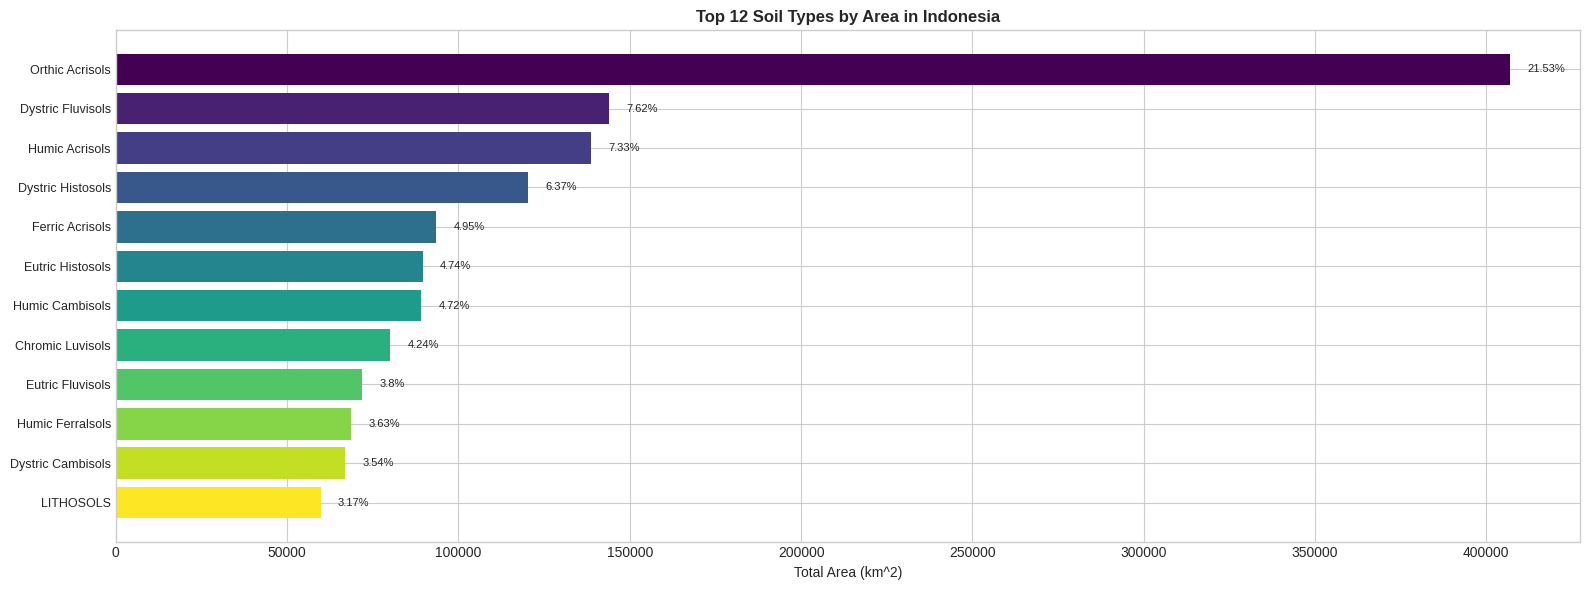

In [449]:
fig, axes = plt.subplots(figsize=(16, 6))
# Bar chart of top soil types by area
top_soils = subgroup_summary.head(12)
bars = axes.barh(range(len(top_soils)), top_soils['Total_Area_km2'], color=plt.cm.viridis(np.linspace(0, 1, len(top_soils))))
axes.set_yticks(range(len(top_soils)))
axes.set_yticklabels(top_soils.index, fontsize=9)
axes.set_xlabel('Total Area (km^2)')
axes.set_title('Top 12 Soil Types by Area in Indonesia', fontweight='bold')
axes.invert_yaxis()

for i, (area, pct) in enumerate(zip(top_soils['Total_Area_km2'], top_soils['Percentage'])):
    axes.text(area + 5000, i, f'{pct}%', va='center', fontsize=8)
    
plt.tight_layout()
plt.show()

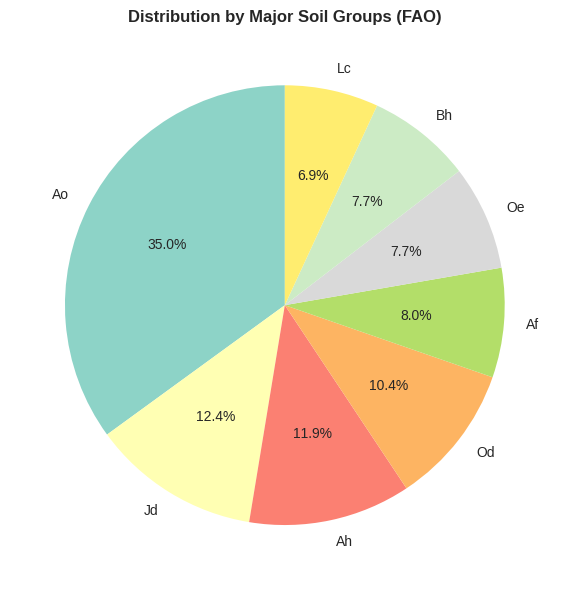

In [450]:
fig, axes = plt.subplots(figsize=(16, 6))
# Aggregate by major soil group
soil_gdf['Major_Group'] = soil_gdf['DOMSOI'].str.extract(r'^([A-Z][a-z]?)')
major_groups = soil_gdf.groupby('Major_Group')['SQKM'].sum().sort_values(ascending=False).head(8)
colors = plt.cm.Set3(np.linspace(0, 1, len(major_groups)))
wedges, texts, autotexts = axes.pie(major_groups.values, labels=major_groups.index, autopct='%1.1f%%', 
                                    colors=colors, startangle=90)
axes.set_title('Distribution by Major Soil Groups (FAO)', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Load Elevation Data (Spot Height)
elevation_50k_path = "SpotHeightIndonesia/Spot Height 50K.shp"
elevation_250k_path = "SpotHeightIndonesia/Spot Height 250K.shp"

# Load both datasets
elevation_50k = gpd.read_file(elevation_50k_path)
elevation_250k = gpd.read_file(elevation_250k_path)

In [452]:
print("\nSpot Height 50K:")
print(f"   Shape: {elevation_50k.shape}")
print(f"   CRS: {elevation_50k.crs}")
print(f"   Columns: {list(elevation_50k.columns)}")


Spot Height 50K:
   Shape: (3832212, 8)
   CRS: EPSG:3857
   Columns: ['OBJECTID', 'NAMOBJ', 'FCODE', 'ELEVAS', 'REMARK', 'SRS_ID', 'GLOBALID', 'geometry']


In [453]:
print("\nSample from 50K:")
display(elevation_50k.head(3))


Sample from 50K:


,OBJECTID,NAMOBJ,FCODE,ELEVAS,REMARK,SRS_ID,GLOBALID,geometry
0,2682897.0,32,30104,32.0,None,None,{634D0812-C1D6-446D-A3D1-FB2C0997C871},POINT (13310112.069 -571663.242)
1,2682898.0,44,30104,44.0,None,None,{12505728-3D16-4B05-A6F5-669EA9136EF4},POINT (13310655.501 -573194.397)
2,2682899.0,24,30104,24.0,None,None,{F4B6FBD6-2266-4475-B54C-614383ED2E9B},POINT (13310932.013 -575761.046)


In [454]:
print("\nSpot Height 250K:")
print(f"   Shape: {elevation_250k.shape}")
print(f"   CRS: {elevation_250k.crs}")
print(f"   Columns: {list(elevation_250k.columns)}")


Spot Height 250K:
   Shape: (79865, 8)
   CRS: EPSG:4326
   Columns: ['OBJECTID', 'NAMOBJ', 'FCODE', 'ELEVAS', 'REMARK', 'SRS_ID', 'GLOBALID', 'geometry']


In [455]:
print("\nSample from 250K:")
display(elevation_250k.head(3))


Sample from 250K:


,OBJECTID,NAMOBJ,FCODE,ELEVAS,REMARK,SRS_ID,GLOBALID,geometry
0,1144.0,None,30104,241.0,Spot Height,None,{BA71667B-70F1-4E44-A9DE-C96BC665A6FD},POINT (100.66707 0.43606)
1,1145.0,None,30104,353.0,Spot Height,None,{531EE78B-7FEA-4DE7-A1BE-CB4CB2C79528},POINT (100.64720 0.45697)
2,1146.0,None,30104,262.0,Spot Height,None,{0C6947E4-2B04-473B-B87B-AB5219A4CB1E},POINT (100.63295 0.47306)


In [456]:
elevation = elevation_250k.copy()

elevation = elevation.dropna(subset=['ELEVAS'])
elevation['ELEVAS'] = pd.to_numeric(elevation['ELEVAS'], errors='coerce')
elevation = elevation[elevation['ELEVAS'] >= 0]  # Remove negative values

print(f"\n Valid elevation points: {len(elevation):,}")
print(f"\n Elevation Statistics:")
print(f"   Min: {elevation['ELEVAS'].min():.0f} m")
print(f"   Max: {elevation['ELEVAS'].max():.0f} m")
print(f"   Mean: {elevation['ELEVAS'].mean():.1f} m")
print(f"   Median: {elevation['ELEVAS'].median():.1f} m")
print(f"   Std Dev: {elevation['ELEVAS'].std():.1f} m")


 Valid elevation points: 79,865

 Elevation Statistics:
   Min: 0 m
   Max: 4767 m
   Mean: 552.7 m
   Median: 299.0 m
   Std Dev: 686.7 m


In [457]:
# Categorize elevation
def categorize_elevation(elev):
    if elev < 100:
        return 'Coastal/Lowland (0-100m)'
    elif elev < 500:
        return 'Low Hills (100-500m)'
    elif elev < 1000:
        return 'Mid Elevation (500-1000m)'
    elif elev < 1500:
        return 'Highland (1000-1500m)'
    else:
        return 'Mountainous (>1500m)'

elevation['Elevation_Category'] = elevation['ELEVAS'].apply(categorize_elevation)

print("\nDistribution by Elevation Category:")
elev_dist = elevation['Elevation_Category'].value_counts()
for cat, count in elev_dist.items():
    print(f"   {cat}: {count:,} points ({count/len(elevation)*100:.1f}%)")


Distribution by Elevation Category:
   Coastal/Lowland (0-100m): 28,060 points (35.1%)
   Low Hills (100-500m): 20,672 points (25.9%)
   Mid Elevation (500-1000m): 15,411 points (19.3%)
   Highland (1000-1500m): 8,507 points (10.7%)
   Mountainous (>1500m): 7,215 points (9.0%)


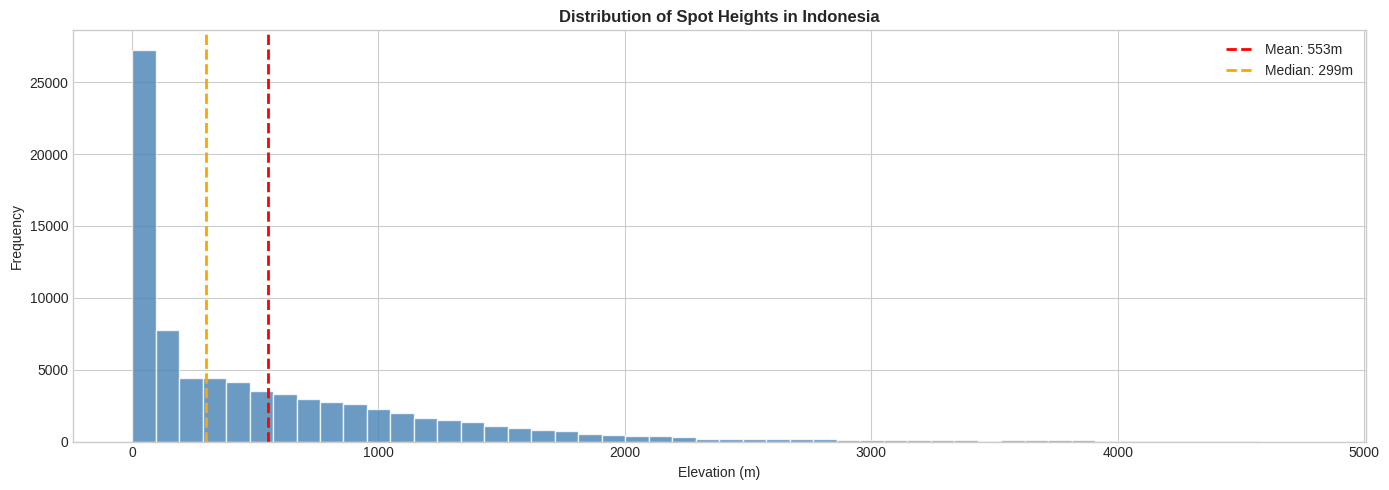

In [458]:
# Visualize Elevation Distribution
fig, axes = plt.subplots(figsize=(14, 5))

# Histogram
axes.hist(elevation['ELEVAS'], bins=50, color='steelblue', edgecolor='white', alpha=0.8)
axes.axvline(elevation['ELEVAS'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {elevation['ELEVAS'].mean():.0f}m")
axes.axvline(elevation['ELEVAS'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {elevation['ELEVAS'].median():.0f}m")
axes.set_xlabel('Elevation (m)')
axes.set_ylabel('Frequency')
axes.set_title('Distribution of Spot Heights in Indonesia', fontweight='bold')
axes.legend()

plt.tight_layout()
plt.show()

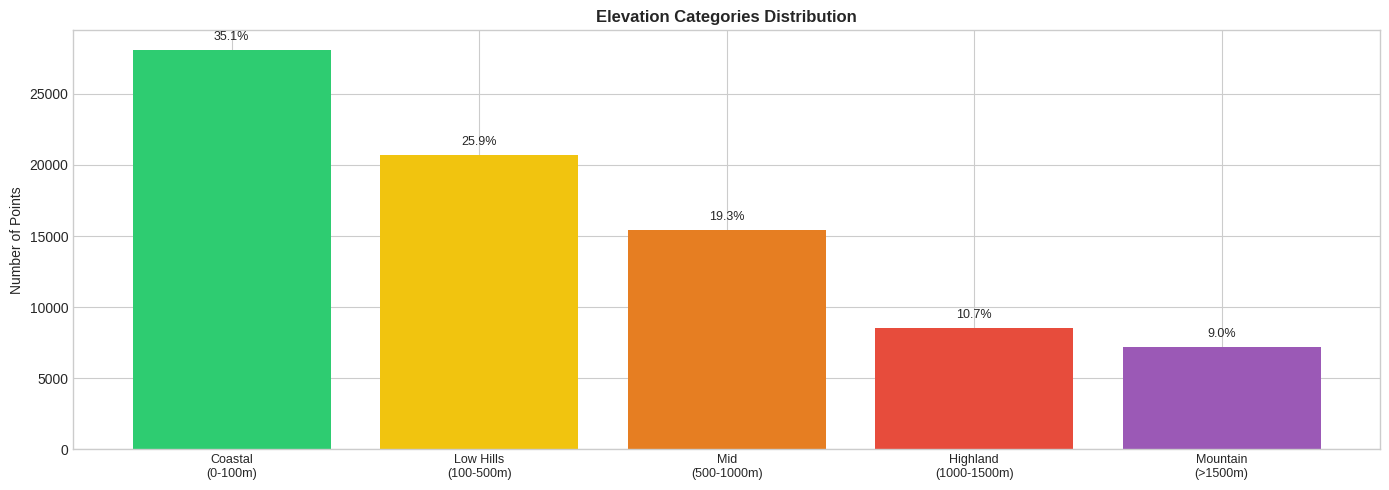

In [459]:
fig, axes = plt.subplots(figsize=(14, 5))
# Bar chart by category
elev_order = ['Coastal/Lowland (0-100m)', 'Low Hills (100-500m)', 'Mid Elevation (500-1000m)', 
              'Highland (1000-1500m)', 'Mountainous (>1500m)']
elev_counts = [elev_dist.get(cat, 0) for cat in elev_order]
colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c', '#9b59b6']
bars = axes.bar(range(len(elev_order)), elev_counts, color=colors)
axes.set_xticks(range(len(elev_order)))
axes.set_xticklabels(['Coastal\n(0-100m)', 'Low Hills\n(100-500m)', 'Mid\n(500-1000m)', 
                     'Highland\n(1000-1500m)', 'Mountain\n(>1500m)'], fontsize=9)
axes.set_ylabel('Number of Points')
axes.set_title('Elevation Categories Distribution', fontweight='bold')

for i, (count, bar) in enumerate(zip(elev_counts, bars)):
    axes.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, f'{count/len(elevation)*100:.1f}%', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Load Rainfall Data
rainfall_path = "Jumlah Curah Hujan dan Jumlah Hari Hujan di Stasiun Pengamatan   BMKG 2011-2015.csv"
rainfall_raw = pd.read_csv(rainfall_path, header=3, encoding='utf-8')

In [461]:
rainfall_raw.shape

(140, 13)

In [462]:
rainfall_raw.columns

Index(['Provinsi', 'Stasiun BMKG', 'Jumlah Curah Hujan (mm)',
       'Jumlah Hari Hujan (hari)', 'Jumlah Curah Hujan (mm).1',
       'Jumlah Hari Hujan (hari).1', 'Jumlah Curah Hujan (mm).2',
       'Jumlah Hari Hujan (hari).2', 'Jumlah Curah Hujan (mm).3',
       'Jumlah Hari Hujan (hari).3', 'Jumlah Curah Hujan (mm).4',
       'Jumlah Hari Hujan (hari).4', 'Unnamed: 12'],
      dtype='object')

In [463]:
rainfall_raw.head(10)

,Provinsi,Stasiun BMKG,Jumlah Curah Hujan (mm),Jumlah Hari Hujan (hari),Jumlah Curah Hujan (mm).1,Jumlah Hari Hujan (hari).1,Jumlah Curah Hujan (mm).2,Jumlah Hari Hujan (hari).2,Jumlah Curah Hujan (mm).3,Jumlah Hari Hujan (hari).3,Jumlah Curah Hujan (mm).4,Jumlah Hari Hujan (hari).4,Unnamed: 12
0,Aceh,Sultan Iskandar Muda,1 268.00,150.0,1 098.00,137.0,1 623.60,151.0,2 264.40,142.0,1 575.00,146.0,NaN
1,Sumatera Utara,Kualanamu1,2 042.00,225.0,3 175.00,227.0,2 627.00,218.0,2 148.00,200.0,975.90,105.0,NaN
2,Sumatera Barat,Sicincin,NaN,NaN,4 339.00,230.0,4 627.40,232.0,2 838.40,163.0,3 548.00,185.0,NaN
3,Riau,Sultan Syarif Kasim II,2 405.00,211.0,2 636.00,217.0,2 628.70,214.0,2 343.70,188.0,2 048.30,140.0,NaN
4,Jambi,Sultan Thaha2,2 295.00,209.0,1 874.00,191.0,2 093.60,229.0,1 781.00,199.0,1 694.90,135.0,NaN
5,Sumatera Selatan,Kenten,2 593.00,217.0,3 083.00,194.0,3 409.20,238.0,1 668.30,176.0,1 947.20,138.0,NaN
6,Bengkulu,Pulau Baai,NaN,NaN,2 545.00,143.0,3 980.90,250.0,3 323.00,174.0,2 668.90,166.0,NaN
7,Lampung,Radin Inten II,1 568.00,118.0,1 685.00,143.0,2 456.70,198.0,1 682.50,178.0,1 628.10,151.0,NaN
8,Kepulauan Bangka Belitung,Depati Amir,2 921.00,213.0,2 018.00,195.0,2 839.20,243.0,1 675.00,179.0,1 534.70,163.0,NaN
9,Kepulauan Riau,Kijang,3 893.00,205.0,3 253.00,202.0,3 389.40,227.0,3 064.00,174.0,2 250.90,174.0,NaN


In [464]:
# Rename columns
rainfall = rainfall_raw.iloc[:34].copy()  # Only first 34 rows contain actual data
rainfall = rainfall.dropna(subset=['Provinsi'])
rainfall.columns = ['Provinsi', 'Stasiun_BMKG', 
                    'CH_2011', 'HH_2011', 
                    'CH_2012', 'HH_2012',
                    'CH_2013', 'HH_2013',
                    'CH_2014', 'HH_2014',
                    'CH_2015', 'HH_2015',
                    'Extra']

In [465]:
# Drop extra column and clean
rainfall = rainfall.drop('Extra', axis=1)

In [466]:
# Convert numeric columns
def clean_numeric(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        # Remove spaces used as thousand separators
        x = x.replace(' ', '').replace(',', '.')
    try:
        return float(x)
    except:
        return np.nan

numeric_cols = ['CH_2011', 'HH_2011', 'CH_2012', 'HH_2012', 'CH_2013', 'HH_2013',
                'CH_2014', 'HH_2014', 'CH_2015', 'HH_2015']

for col in numeric_cols:
    rainfall[col] = rainfall[col].apply(clean_numeric)

In [467]:
rainfall.shape

(34, 12)

In [468]:
rainfall['Provinsi'].nunique()

34

In [469]:
rainfall.head(10)

,Provinsi,Stasiun_BMKG,CH_2011,HH_2011,CH_2012,HH_2012,CH_2013,HH_2013,CH_2014,HH_2014,CH_2015,HH_2015
0,Aceh,Sultan Iskandar Muda,1268.0,150.0,1098.0,137.0,1623.6,151.0,2264.4,142.0,1575.0,146.0
1,Sumatera Utara,Kualanamu1,2042.0,225.0,3175.0,227.0,2627.0,218.0,2148.0,200.0,975.9,105.0
2,Sumatera Barat,Sicincin,NaN,NaN,4339.0,230.0,4627.4,232.0,2838.4,163.0,3548.0,185.0
3,Riau,Sultan Syarif Kasim II,2405.0,211.0,2636.0,217.0,2628.7,214.0,2343.7,188.0,2048.3,140.0
4,Jambi,Sultan Thaha2,2295.0,209.0,1874.0,191.0,2093.6,229.0,1781.0,199.0,1694.9,135.0
5,Sumatera Selatan,Kenten,2593.0,217.0,3083.0,194.0,3409.2,238.0,1668.3,176.0,1947.2,138.0
6,Bengkulu,Pulau Baai,NaN,NaN,2545.0,143.0,3980.9,250.0,3323.0,174.0,2668.9,166.0
7,Lampung,Radin Inten II,1568.0,118.0,1685.0,143.0,2456.7,198.0,1682.5,178.0,1628.1,151.0
8,Kepulauan Bangka Belitung,Depati Amir,2921.0,213.0,2018.0,195.0,2839.2,243.0,1675.0,179.0,1534.7,163.0
9,Kepulauan Riau,Kijang,3893.0,205.0,3253.0,202.0,3389.4,227.0,3064.0,174.0,2250.9,174.0


In [470]:
# Calculate aggregated rainfall features per province
rainfall['Mean_Annual_Rainfall'] = rainfall[['CH_2011', 'CH_2012', 'CH_2013', 'CH_2014', 'CH_2015']].mean(axis=1)
rainfall['Mean_Rainy_Days'] = rainfall[['HH_2011', 'HH_2012', 'HH_2013', 'HH_2014', 'HH_2015']].mean(axis=1)
rainfall['Rainfall_Variability'] = rainfall[['CH_2011', 'CH_2012', 'CH_2013', 'CH_2014', 'CH_2015']].std(axis=1)
rainfall['CV_Rainfall'] = (rainfall['Rainfall_Variability'] / rainfall['Mean_Annual_Rainfall'] * 100).round(2)  # Coefficient of Variation

# Calculate rainfall intensity (mm per rainy day)
rainfall['Rainfall_Intensity'] = (rainfall['Mean_Annual_Rainfall'] / rainfall['Mean_Rainy_Days']).round(2)

# Categorize rainfall
def categorize_rainfall(rain):
    if pd.isna(rain):
        return 'Unknown'
    elif rain < 1500:
        return 'Dry (<1500mm)'
    elif rain < 2500:
        return 'Moderate (1500-2500mm)'
    elif rain < 3500:
        return 'Wet (2500-3500mm)'
    else:
        return 'Very Wet (>3500mm)'

rainfall['Rainfall_Category'] = rainfall['Mean_Annual_Rainfall'].apply(categorize_rainfall)

In [471]:
rainfall_summary = rainfall[['Provinsi', 'Stasiun_BMKG', 'Mean_Annual_Rainfall', 'Mean_Rainy_Days', 
                              'Rainfall_Variability', 'CV_Rainfall', 'Rainfall_Intensity', 'Rainfall_Category']].copy()
rainfall_summary = rainfall_summary.sort_values('Mean_Annual_Rainfall', ascending=False)

In [472]:
print(f"Rainfall Statistics:")
print(f"   Min: {rainfall['Mean_Annual_Rainfall'].min():.0f} mm/year")
print(f"   Max: {rainfall['Mean_Annual_Rainfall'].max():.0f} mm/year")
print(f"   Mean: {rainfall['Mean_Annual_Rainfall'].mean():.0f} mm/year")

Rainfall Statistics:
   Min: 700 mm/year
   Max: 3838 mm/year
   Mean: 2318 mm/year


In [473]:
print(f"Rainfall Categories:")
for cat, count in rainfall['Rainfall_Category'].value_counts().items():
    print(f"   {cat}: {count} provinces")

Rainfall Categories:
   Moderate (1500-2500mm): 19 provinces
   Wet (2500-3500mm): 12 provinces
   Dry (<1500mm): 2 provinces
   Very Wet (>3500mm): 1 provinces


In [474]:
rainfall_summary

,Provinsi,Stasiun_BMKG,Mean_Annual_Rainfall,Mean_Rainy_Days,Rainfall_Variability,CV_Rainfall,Rainfall_Intensity,Rainfall_Category
2,Sumatera Barat,Sicincin,3838.200,202.500000,807.765098,21.05,18.95,Very Wet (>3500mm)
30,Maluku,Pattimura,3402.300,219.750000,1376.693706,40.46,15.48,Wet (2500-3500mm)
26,Sulawesi Selatan,Maros4,3210.400,185.000000,594.286799,18.51,17.35,Wet (2500-3500mm)
9,Kepulauan Riau,Kijang,3170.060,196.400000,598.693401,18.89,16.14,Wet (2500-3500mm)
6,Bengkulu,Pulau Baai,3129.450,183.250000,662.348551,21.17,17.08,Wet (2500-3500mm)
19,Kalimantan Barat,Supadio,3020.960,211.500000,267.214657,8.85,14.28,Wet (2500-3500mm)
32,Papua Barat,Rendani,3011.860,240.400000,322.380533,10.70,12.53,Wet (2500-3500mm)
20,Kalimantan Tengah,Tjilik Riwut,2978.480,199.800000,354.177084,11.89,14.91,Wet (2500-3500mm)
24,Sulawesi Utara,Kayuwatu,2881.160,225.400000,689.039424,23.92,12.78,Wet (2500-3500mm)
23,Kalimantan Utara,Tanjung Harapan,2706.700,222.333333,423.659498,15.65,12.17,Wet (2500-3500mm)


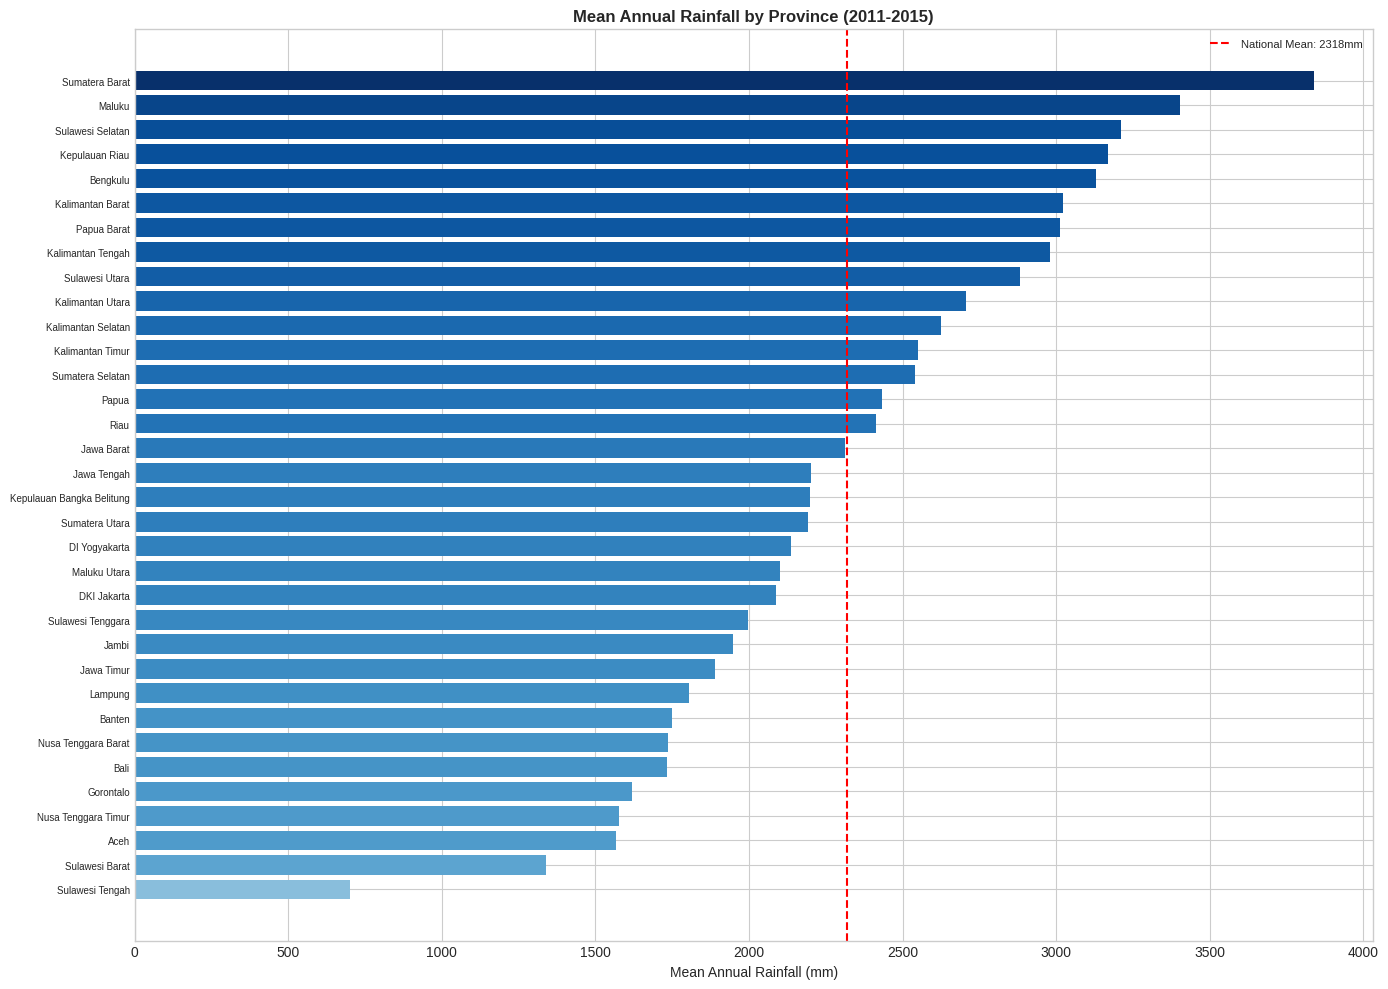

In [475]:
# Visualize Rainfall Data
fig, axes = plt.subplots(figsize=(14, 10))

#mean annual rainfall by province
sorted_rainfall = rainfall.sort_values('Mean_Annual_Rainfall', ascending=True)
colors = [plt.cm.Blues(0.3 + 0.7*x/sorted_rainfall['Mean_Annual_Rainfall'].max()) for x in sorted_rainfall['Mean_Annual_Rainfall']]
axes.barh(range(len(sorted_rainfall)), sorted_rainfall['Mean_Annual_Rainfall'], color=colors)
axes.set_yticks(range(len(sorted_rainfall)))
axes.set_yticklabels(sorted_rainfall['Provinsi'], fontsize=7)
axes.set_xlabel('Mean Annual Rainfall (mm)')
axes.set_title('Mean Annual Rainfall by Province (2011-2015)', fontweight='bold')
axes.axvline(rainfall['Mean_Annual_Rainfall'].mean(), color='red', linestyle='--', linewidth=1.5, 
            label=f"National Mean: {rainfall['Mean_Annual_Rainfall'].mean():.0f}mm")
axes.legend(fontsize=8)

plt.tight_layout()
plt.show()

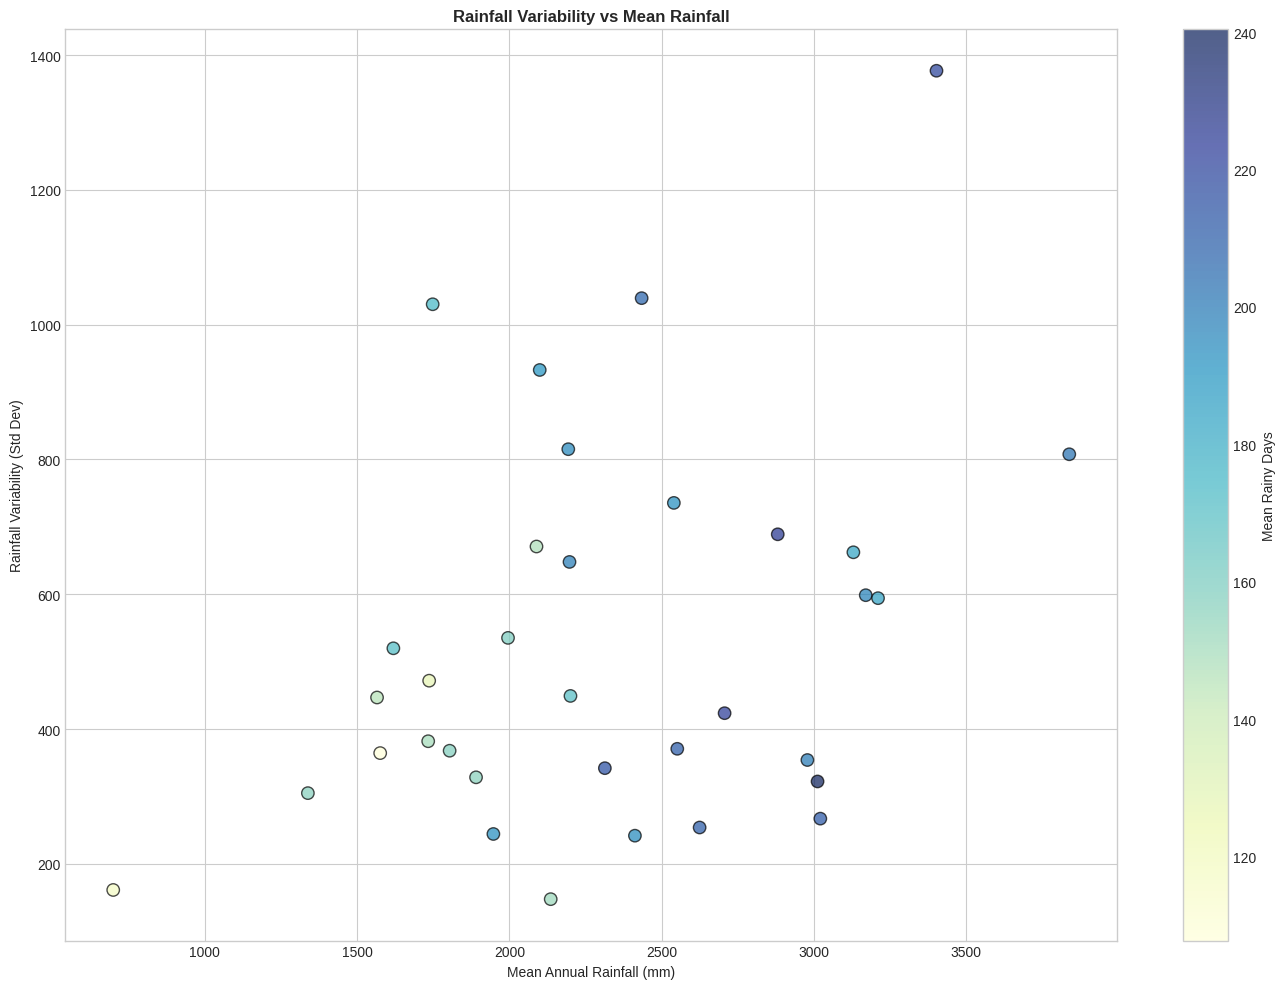

In [476]:
fig, axes = plt.subplots(figsize=(14, 10))

# Rainfall variability vs mean rainfall
scatter = axes.scatter(rainfall['Mean_Annual_Rainfall'], rainfall['Rainfall_Variability'], 
                       c=rainfall['Mean_Rainy_Days'], cmap='YlGnBu', s=80, alpha=0.7, edgecolors='black')
axes.set_xlabel('Mean Annual Rainfall (mm)')
axes.set_ylabel('Rainfall Variability (Std Dev)')
axes.set_title('Rainfall Variability vs Mean Rainfall', fontweight='bold')
plt.colorbar(scatter, ax=axes, label='Mean Rainy Days')

plt.tight_layout()
plt.show()

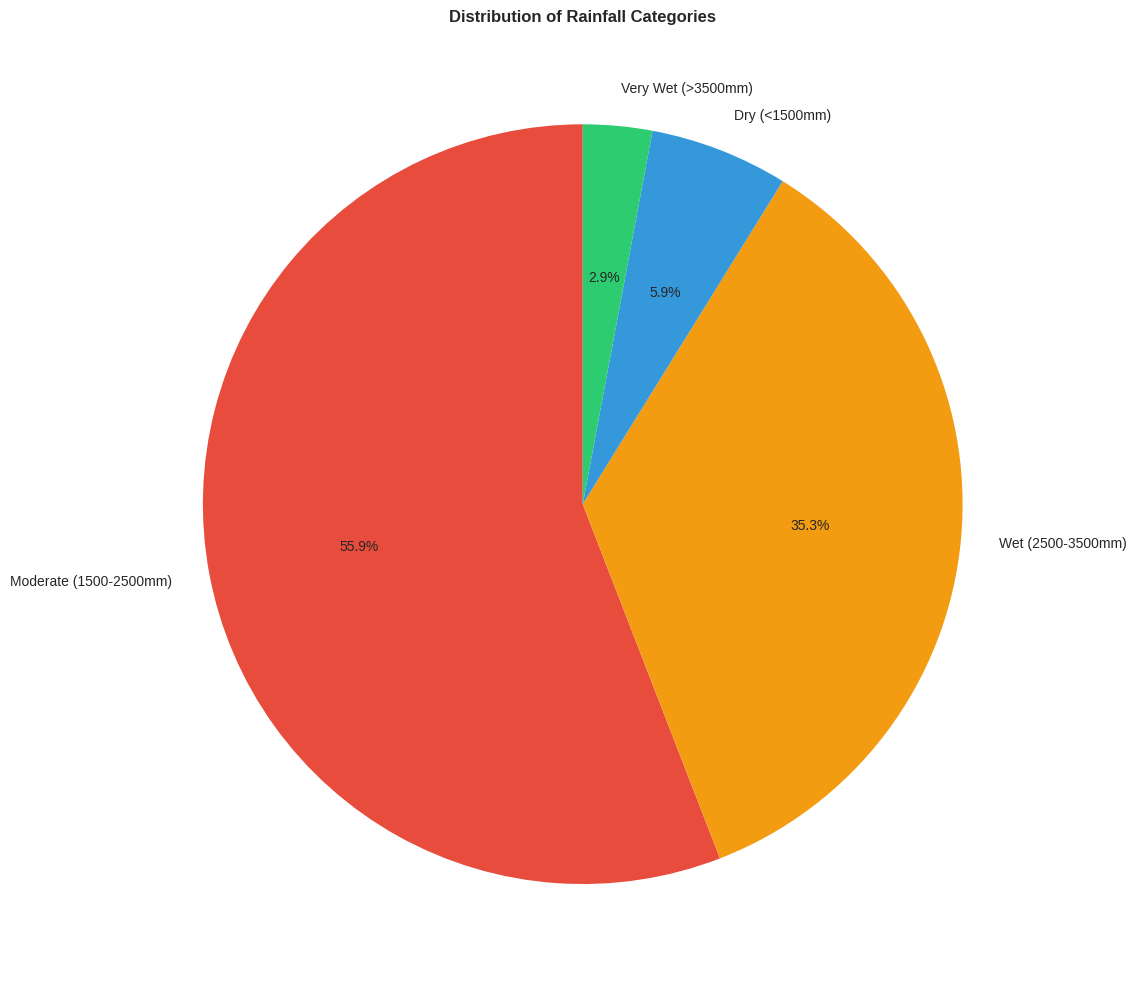

In [477]:
fig, axes = plt.subplots(figsize=(14, 10))

# Distribution of rainfall categories
cat_counts = rainfall['Rainfall_Category'].value_counts()
colors_cat = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']
axes.pie(cat_counts.values, labels=cat_counts.index, autopct='%1.1f%%', colors=colors_cat, startangle=90)
axes.set_title('Distribution of Rainfall Categories', fontweight='bold')

plt.tight_layout()
plt.show()

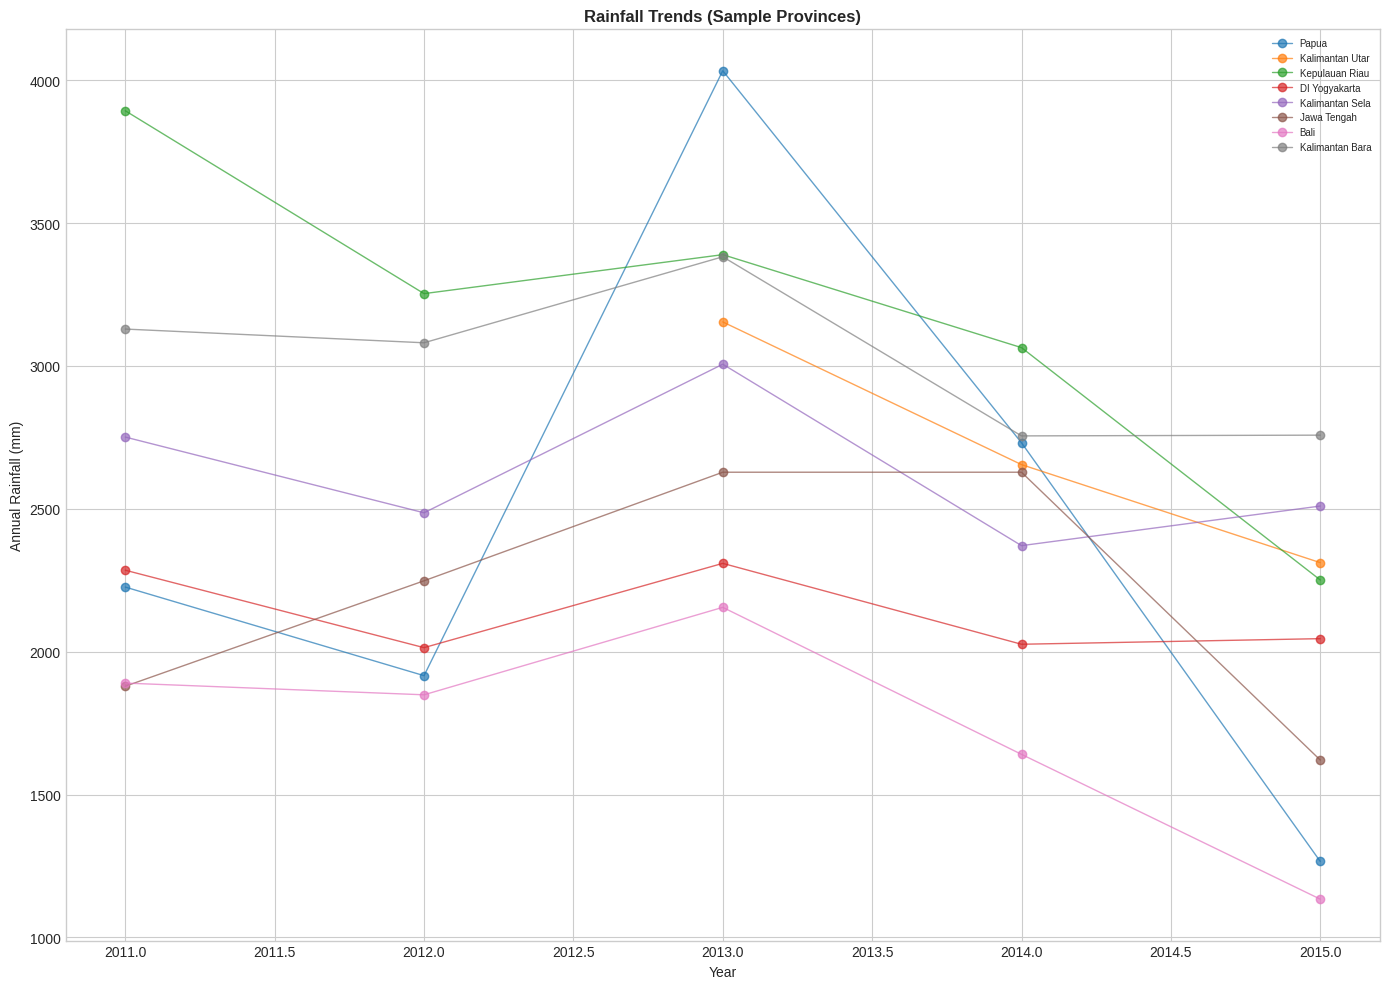

In [478]:
fig, axes = plt.subplots(figsize=(14, 10))

# Rainfall time series trends
years = [2011, 2012, 2013, 2014, 2015]
for idx, row in rainfall.sample(min(8, len(rainfall))).iterrows():
    values = [row['CH_2011'], row['CH_2012'], row['CH_2013'], row['CH_2014'], row['CH_2015']]
    axes.plot(years, values, marker='o', linewidth=1, alpha=0.7, label=row['Provinsi'][:15])
axes.set_xlabel('Year')
axes.set_ylabel('Annual Rainfall (mm)')
axes.set_title('Rainfall Trends (Sample Provinces)', fontweight='bold')
axes.legend(fontsize=7, loc='upper right')

plt.tight_layout()
plt.show()

In [479]:
soil_area = soil_gdf.groupby('Sub_Group_')['SQKM'].sum().sort_values(ascending=False)
len(soil_area)

45

In [480]:
# For clustering, we'll group soil types into agroecologically meaningful categories
def classify_soil_agriculture(soil_type):
    """Classify soil types into agricultural categories"""
    soil_type = str(soil_type).upper()
    
    # Alluvial/Fluvisols - Good for irrigated crops (rice)
    if 'FLUVISOL' in soil_type or 'ALLUVIAL' in soil_type:
        return 'Alluvial'
    
    # Volcanic soils (Andosols) - Excellent fertility
    elif 'ANDOSOL' in soil_type or 'VOLCANIC' in soil_type:
        return 'Volcanic'
    
    # Organic soils (Histosols) - Peat, suitable for sago
    elif 'HISTOSOL' in soil_type or 'PEAT' in soil_type or 'ORGANIC' in soil_type:
        return 'Organic_Peat'
    
    # Lateritic/Weathered (Ferralsols, Acrisols) - Low fertility, need management
    elif 'FERRAL' in soil_type or 'ACRISOL' in soil_type or 'LATERIT' in soil_type:
        return 'Lateritic_Weathered'
    
    # Calcareous (Rendzinas, Luvisols) - Suitable for specific crops
    elif 'RENDZINA' in soil_type or 'LUVISOL' in soil_type or 'CALC' in soil_type:
        return 'Calcareous'
    
    # Sandy (Arenosols) - Well-drained, specific crops
    elif 'ARENOSOL' in soil_type or 'SANDY' in soil_type:
        return 'Sandy'
    
    # Clayey/Heavy (Vertisols, Gleysols) - Rice, flood-tolerant crops
    elif 'VERTISOL' in soil_type or 'GLEYSOL' in soil_type or 'CLAY' in soil_type:
        return 'Clayey_Hydromorphic'
    
    # Rocky/Shallow (Lithosols) - Limited agriculture
    elif 'LITHOSOL' in soil_type or 'ROCK' in soil_type:
        return 'Rocky_Shallow'
    
    # General Cambisols - Moderate fertility
    elif 'CAMBISOL' in soil_type:
        return 'Cambisol'
    
    else:
        return 'Other'

soil_gdf['Agri_Soil_Class'] = soil_gdf['Sub_Group_'].apply(classify_soil_agriculture)
agri_soil_summary = soil_gdf.groupby('Agri_Soil_Class')['SQKM'].sum().sort_values(ascending=False)

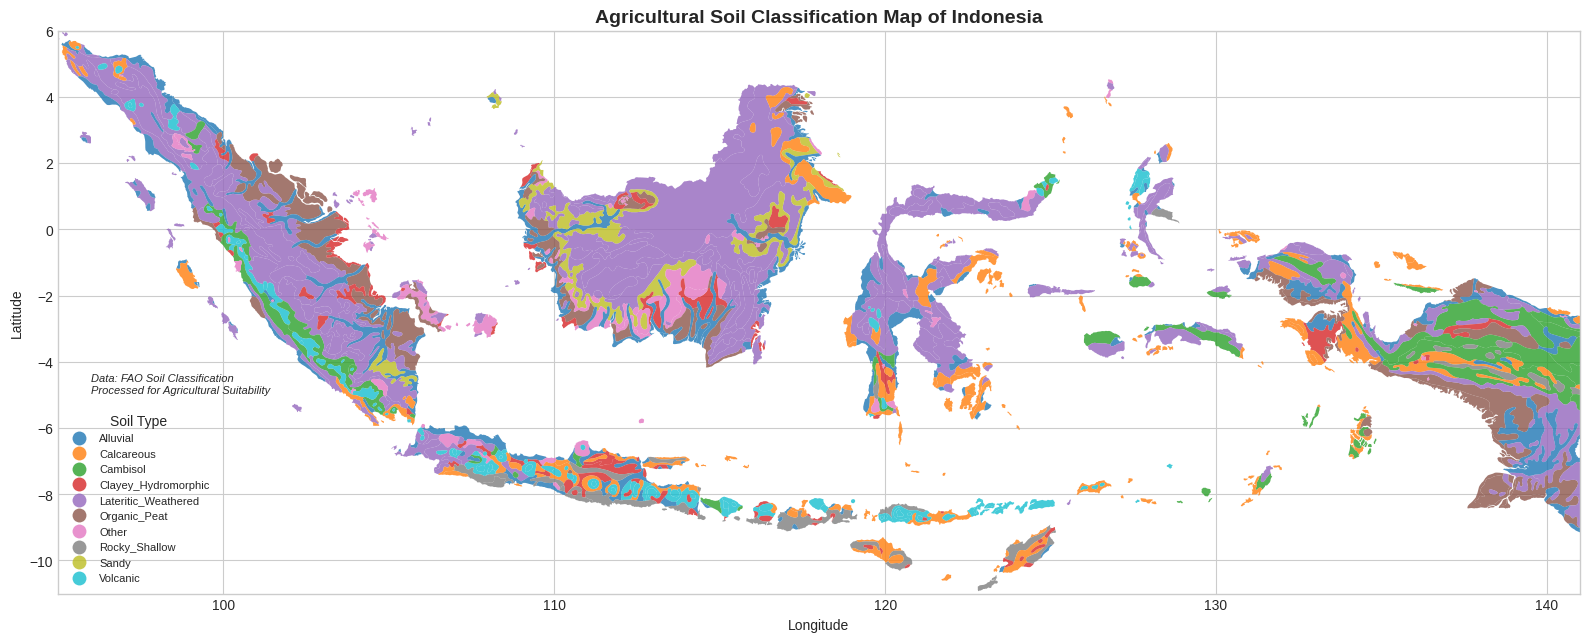

In [481]:
fig, ax = plt.subplots(figsize=(16, 10))

# Create colormap for agricultural soil classes
agri_soil_colors = {
    'Alluvial': '#3498db',
    'Volcanic': '#e74c3c',
    'Organic_Peat': '#27ae60',
    'Lateritic_Weathered': '#f39c12',
    'Calcareous': '#9b59b6',
    'Sandy': '#f1c40f',
    'Clayey_Hydromorphic': '#1abc9c',
    'Rocky_Shallow': '#95a5a6',
    'Cambisol': '#e67e22',
    'Other': '#7f8c8d'
}

# Plot soil map
soil_gdf.plot(column='Agri_Soil_Class', ax=ax, legend=True, 
              cmap='tab10', edgecolor='none', alpha=0.8,
              legend_kwds={'loc': 'lower left', 'fontsize': 8, 'title': 'Soil Type'})

ax.set_title('Agricultural Soil Classification Map of Indonesia', fontweight='bold', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(95, 141)
ax.set_ylim(-11, 6)

# Add text annotation
ax.text(96, -5, 'Data: FAO Soil Classification\nProcessed for Agricultural Suitability', 
        fontsize=8, style='italic', verticalalignment='bottom')

plt.tight_layout()
plt.show()

In [482]:
for soil_class, area in agri_soil_summary.items():
    pct = area / agri_soil_summary.sum() * 100
    print(f"   {soil_class}: {area:,.0f} km² ({pct:.1f}%)")

   Lateritic_Weathered: 789,361 km² (41.7%)
   Alluvial: 217,928 km² (11.5%)
   Organic_Peat: 209,944 km² (11.1%)
   Cambisol: 166,295 km² (8.8%)
   Calcareous: 165,852 km² (8.8%)
   Volcanic: 75,569 km² (4.0%)
   Clayey_Hydromorphic: 73,678 km² (3.9%)
   Sandy: 68,404 km² (3.6%)
   Other: 67,819 km² (3.6%)
   Rocky_Shallow: 59,845 km² (3.2%)


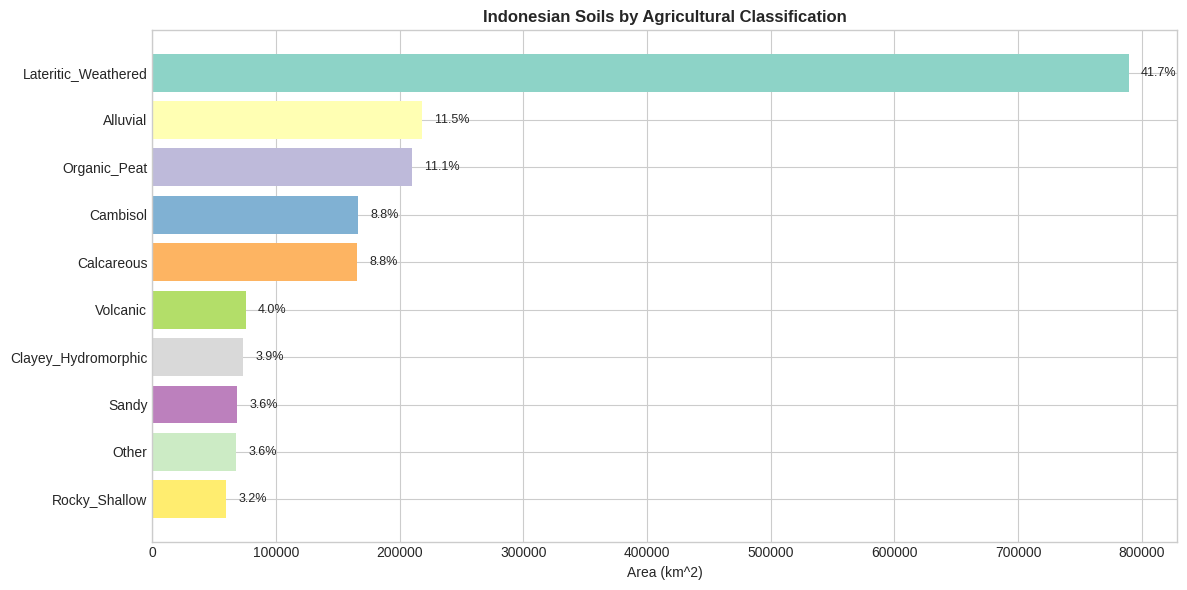

In [483]:
# Visualize Agricultural Soil Classification
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.Set3(np.linspace(0, 1, len(agri_soil_summary)))
bars = ax.barh(range(len(agri_soil_summary)), agri_soil_summary.values, color=colors)
ax.set_yticks(range(len(agri_soil_summary)))
ax.set_yticklabels(agri_soil_summary.index)
ax.set_xlabel('Area (km^2)')
ax.set_title('Indonesian Soils by Agricultural Classification', fontweight='bold', fontsize=12)
ax.invert_yaxis()

# Add percentage labels
for i, (v, pct) in enumerate(zip(agri_soil_summary.values, agri_soil_summary.values/agri_soil_summary.sum()*100)):
    ax.text(v + 10000, i, f'{pct:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [484]:
# Build the Feature Matrix for Clustering
features_df = rainfall[['Provinsi', 'Mean_Annual_Rainfall', 'Mean_Rainy_Days', 
                         'Rainfall_Variability', 'CV_Rainfall', 'Rainfall_Intensity']].copy()
features_df = features_df.reset_index(drop=True)

In [485]:
# Create derived climate indices
features_df['Aridity_Index'] = features_df['Mean_Annual_Rainfall'] / 2500  # Normalized to typical humid tropical

# Rainfall Seasonality Proxy
features_df['Seasonality_Index'] = features_df['CV_Rainfall'] / 100

# Wetness Duration (proxy for continuous wet conditions)
features_df['Wetness_Duration'] = features_df['Mean_Rainy_Days'] / 365

In [486]:
# Climate Zone Classification
def classify_climate_zone(row):
    rainfall = row['Mean_Annual_Rainfall']
    rainy_days = row['Mean_Rainy_Days']
    
    if pd.isna(rainfall) or pd.isna(rainy_days):
        return 'Unknown'
    elif rainfall >= 3000 and rainy_days >= 200:
        return 'Equatorial_Humid'
    elif rainfall >= 2000 and rainy_days >= 150:
        return 'Tropical_Wet'
    elif rainfall >= 1500 and rainy_days >= 120:
        return 'Tropical_Moist'
    elif rainfall >= 1000:
        return 'Tropical_Seasonal'
    else:
        return 'Semi_Arid'

features_df['Climate_Zone'] = features_df.apply(classify_climate_zone, axis=1)

In [487]:
# Regional Classification based on Indonesian geography
def classify_region(province):
    province = str(province).upper()
    
    # Sumatra
    if any(x in province for x in ['ACEH', 'SUMATERA', 'RIAU', 'JAMBI', 'BENGKULU', 'LAMPUNG', 'BANGKA']):
        return 'Sumatra'
    # Java-Bali
    elif any(x in province for x in ['JAKARTA', 'JAWA', 'BANTEN', 'YOGYAKARTA', 'BALI']):
        return 'Java_Bali'
    # Kalimantan
    elif 'KALIMANTAN' in province:
        return 'Kalimantan'
    # Sulawesi
    elif 'SULAWESI' in province or 'GORONTALO' in province:
        return 'Sulawesi'
    # Nusa Tenggara
    elif 'NUSA TENGGARA' in province:
        return 'Nusa_Tenggara'
    # Maluku & Papua
    elif any(x in province for x in ['MALUKU', 'PAPUA']):
        return 'Maluku_Papua'
    else:
        return 'Other'

features_df['Region'] = features_df['Provinsi'].apply(classify_region)

In [488]:
features_df.shape

(34, 11)

In [489]:
len(features_df)

34

In [490]:
print(f"Features Created:")
for col in features_df.columns:
    print(f"   - {col}")

Features Created:
   - Provinsi
   - Mean_Annual_Rainfall
   - Mean_Rainy_Days
   - Rainfall_Variability
   - CV_Rainfall
   - Rainfall_Intensity
   - Aridity_Index
   - Seasonality_Index
   - Wetness_Duration
   - Climate_Zone
   - Region


In [491]:
features_df.head(10)

,Provinsi,Mean_Annual_Rainfall,Mean_Rainy_Days,Rainfall_Variability,CV_Rainfall,Rainfall_Intensity,Aridity_Index,Seasonality_Index,Wetness_Duration,Climate_Zone,Region
0,Aceh,1565.80,145.20,446.930957,28.54,10.78,0.626320,0.2854,0.397808,Tropical_Moist,Sumatra
1,Sumatera Utara,2193.58,195.00,815.296990,37.17,11.25,0.877432,0.3717,0.534247,Tropical_Wet,Sumatra
2,Sumatera Barat,3838.20,202.50,807.765098,21.05,18.95,1.535280,0.2105,0.554795,Equatorial_Humid,Sumatra
3,Riau,2412.34,194.00,241.932786,10.03,12.43,0.964936,0.1003,0.531507,Tropical_Wet,Sumatra
4,Jambi,1947.70,192.60,244.454761,12.55,10.11,0.779080,0.1255,0.527671,Tropical_Moist,Sumatra
5,Sumatera Selatan,2540.14,192.60,735.601671,28.96,13.19,1.016056,0.2896,0.527671,Tropical_Wet,Sumatra
6,Bengkulu,3129.45,183.25,662.348551,21.17,17.08,1.251780,0.2117,0.502055,Tropical_Wet,Sumatra
7,Lampung,1804.06,157.60,367.959689,20.40,11.45,0.721624,0.2040,0.431781,Tropical_Moist,Sumatra
8,Kepulauan Bangka Belitung,2197.58,198.60,648.028056,29.49,11.07,0.879032,0.2949,0.544110,Tropical_Wet,Sumatra
9,Kepulauan Riau,3170.06,196.40,598.693401,18.89,16.14,1.268024,0.1889,0.538082,Tropical_Wet,Sumatra


In [492]:
# Add soil suitability indices based on regional characteristics
def get_soil_suitability(region, climate_zone):
    """Values represent relative suitability scores (0-1 scale)."""
    soil_scores = {
        'Alluvial': 0.5, 'Volcanic': 0.5, 'Organic_Peat': 0.5, 
        'Lateritic': 0.5, 'Calcareous': 0.5
    }
    
    if region == 'Sumatra':
        # Sumatra: High peat, good alluvial, some volcanic
        soil_scores = {'Alluvial': 0.7, 'Volcanic': 0.3, 'Organic_Peat': 0.8, 
                       'Lateritic': 0.6, 'Calcareous': 0.2}
    elif region == 'Java_Bali':
        # Java/Bali: Excellent volcanic, good alluvial
        soil_scores = {'Alluvial': 0.8, 'Volcanic': 0.9, 'Organic_Peat': 0.1, 
                       'Lateritic': 0.3, 'Calcareous': 0.4}
    elif region == 'Kalimantan':
        # Kalimantan: Dominant peat, lateritic
        soil_scores = {'Alluvial': 0.5, 'Volcanic': 0.1, 'Organic_Peat': 0.9, 
                       'Lateritic': 0.8, 'Calcareous': 0.1}
    elif region == 'Sulawesi':
        # Sulawesi: Mixed, calcareous in some areas
        soil_scores = {'Alluvial': 0.6, 'Volcanic': 0.4, 'Organic_Peat': 0.3, 
                       'Lateritic': 0.6, 'Calcareous': 0.7}
    elif region == 'Nusa_Tenggara':
        # Nusa Tenggara: Calcareous, volcanic, drier soils
        soil_scores = {'Alluvial': 0.4, 'Volcanic': 0.6, 'Organic_Peat': 0.05, 
                       'Lateritic': 0.4, 'Calcareous': 0.8}
    elif region == 'Maluku_Papua':
        # Maluku/Papua: High organic/peat in Papua, mixed in Maluku
        soil_scores = {'Alluvial': 0.6, 'Volcanic': 0.3, 'Organic_Peat': 0.7, 
                       'Lateritic': 0.7, 'Calcareous': 0.3}
    
    return soil_scores

In [493]:
# Apply soil indices
for idx, row in features_df.iterrows():
    scores = get_soil_suitability(row['Region'], row['Climate_Zone'])
    for soil_type, score in scores.items():
        features_df.loc[idx, f'Soil_{soil_type}'] = score

# Calculate composite soil quality index
features_df['Soil_Quality_Index'] = (
    features_df['Soil_Volcanic'] * 0.3 + 
    features_df['Soil_Alluvial'] * 0.25 + 
    features_df['Soil_Organic_Peat'] * 0.15 + 
    features_df['Soil_Calcareous'] * 0.15 +
    features_df['Soil_Lateritic'] * 0.15
)

print(features_df[['Provinsi', 'Region', 'Soil_Alluvial', 'Soil_Volcanic', 
                   'Soil_Organic_Peat', 'Soil_Quality_Index']].head(10))

                    Provinsi   Region  Soil_Alluvial  Soil_Volcanic  \
0                       Aceh  Sumatra            0.7            0.3   
1             Sumatera Utara  Sumatra            0.7            0.3   
2             Sumatera Barat  Sumatra            0.7            0.3   
3                       Riau  Sumatra            0.7            0.3   
4                      Jambi  Sumatra            0.7            0.3   
5           Sumatera Selatan  Sumatra            0.7            0.3   
6                   Bengkulu  Sumatra            0.7            0.3   
7                    Lampung  Sumatra            0.7            0.3   
8  Kepulauan Bangka Belitung  Sumatra            0.7            0.3   
9             Kepulauan Riau  Sumatra            0.7            0.3   

   Soil_Organic_Peat  Soil_Quality_Index  
0                0.8               0.505  
1                0.8               0.505  
2                0.8               0.505  
3                0.8               0.505  
4  

In [494]:
numeric_features = [
    'Mean_Annual_Rainfall',
    'Mean_Rainy_Days',
    'Rainfall_Variability',
    'Soil_Quality_Index'
]


In [495]:
X_raw = features_df[numeric_features].copy()

In [496]:
X_raw.isnull().sum()

Mean_Annual_Rainfall    0
Mean_Rainy_Days         0
Rainfall_Variability    0
Soil_Quality_Index      0
dtype: int64

In [497]:
X_raw = X_raw.fillna(X_raw.median())

In [498]:
X_raw.isnull().sum().sum()

0

In [499]:
# Standardize features
X_scaled = StandardScaler().fit_transform(
    features_df[numeric_features]
)
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_features)

In [500]:
X_scaled_df.shape

(34, 4)

In [501]:
X_scaled_df.describe().round(2)

,Mean_Annual_Rainfall,Mean_Rainy_Days,Rainfall_Variability,Soil_Quality_Index
count,34.00,34.00,34.00,34.00
mean,0.00,0.00,-0.00,-0.00
std,1.02,1.02,1.02,1.02
min,-2.45,-2.34,-1.37,-1.66
25%,-0.75,-0.79,-0.70,-0.26
50%,-0.18,0.31,-0.28,-0.06
75%,0.79,0.76,0.51,0.04
max,2.30,1.84,3.08,1.63


In [502]:
province_names = features_df['Provinsi'].values

In [503]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)

In [504]:
# Determine optimal number of clusters
k_range = range(2, 11)

# Store metrics
inertias = []
silhouettes = []
calinski_scores = []
davies_bouldin_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_pca)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_pca, labels))
    calinski_scores.append(calinski_harabasz_score(X_pca, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_pca, labels))
    
    print(f"k={k}: Silhouette={silhouettes[-1]:.3f}, Calinski={calinski_scores[-1]:.1f}, Davies-Bouldin={davies_bouldin_scores[-1]:.3f}")

k=2: Silhouette=0.377, Calinski=24.7, Davies-Bouldin=1.049
k=3: Silhouette=0.391, Calinski=22.4, Davies-Bouldin=0.877
k=4: Silhouette=0.424, Calinski=25.3, Davies-Bouldin=0.873
k=5: Silhouette=0.414, Calinski=23.4, Davies-Bouldin=0.738
k=6: Silhouette=0.385, Calinski=23.0, Davies-Bouldin=0.761
k=7: Silhouette=0.393, Calinski=24.7, Davies-Bouldin=0.830
k=8: Silhouette=0.416, Calinski=25.0, Davies-Bouldin=0.644
k=9: Silhouette=0.371, Calinski=26.3, Davies-Bouldin=0.689
k=10: Silhouette=0.402, Calinski=28.1, Davies-Bouldin=0.675


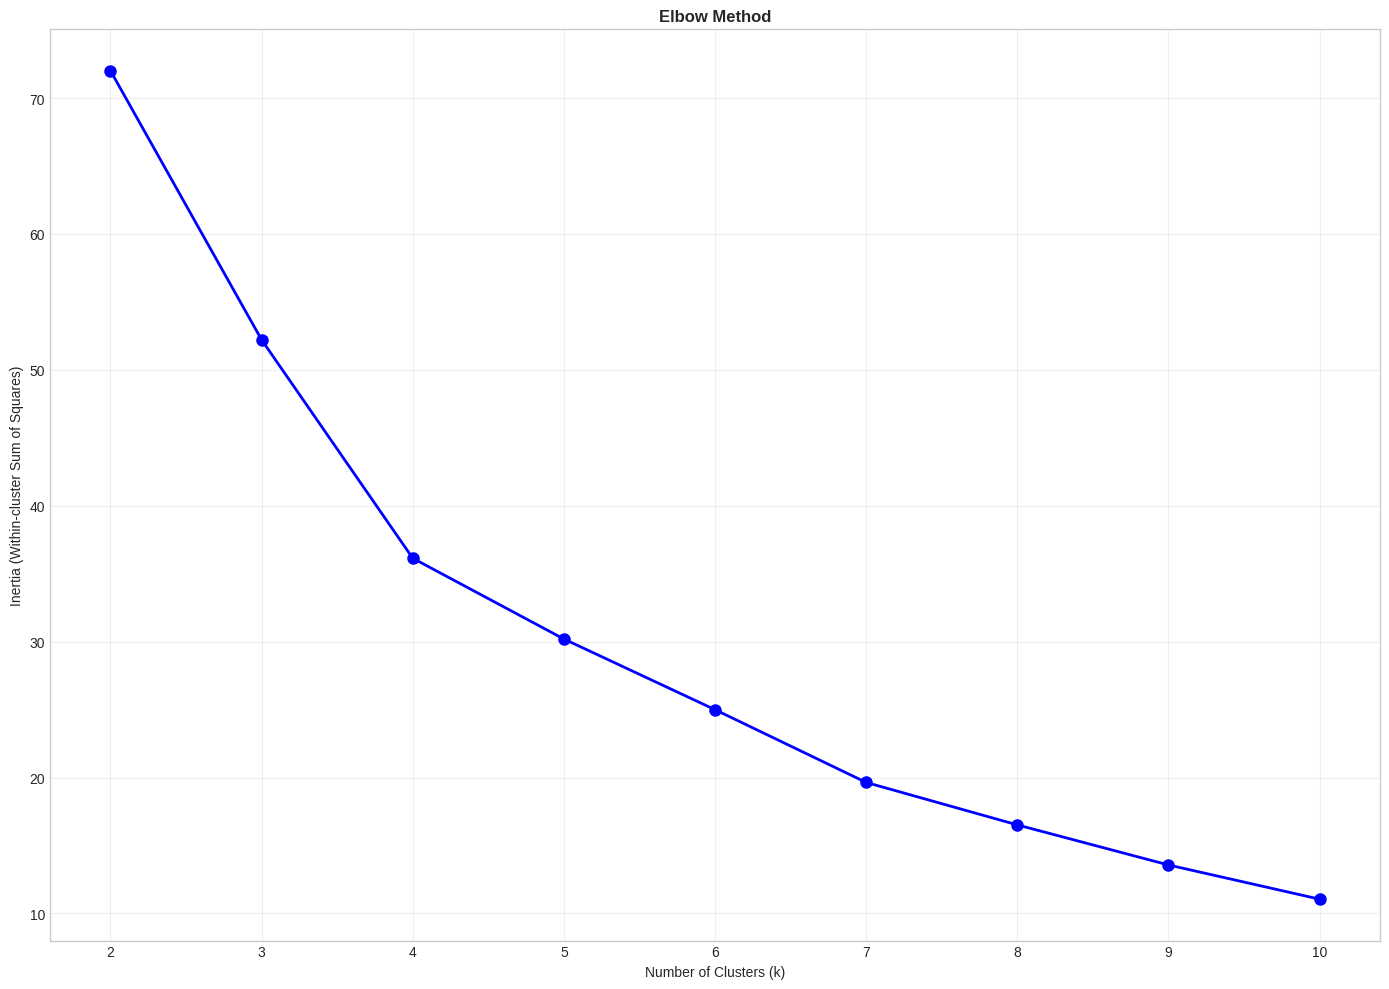

In [505]:
# Visualize cluster evaluation metrics
fig, axes = plt.subplots(figsize=(14, 10))

# Elbow Method
axes.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes.set_xlabel('Number of Clusters (k)')
axes.set_ylabel('Inertia (Within-cluster Sum of Squares)')
axes.set_title('Elbow Method', fontweight='bold')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

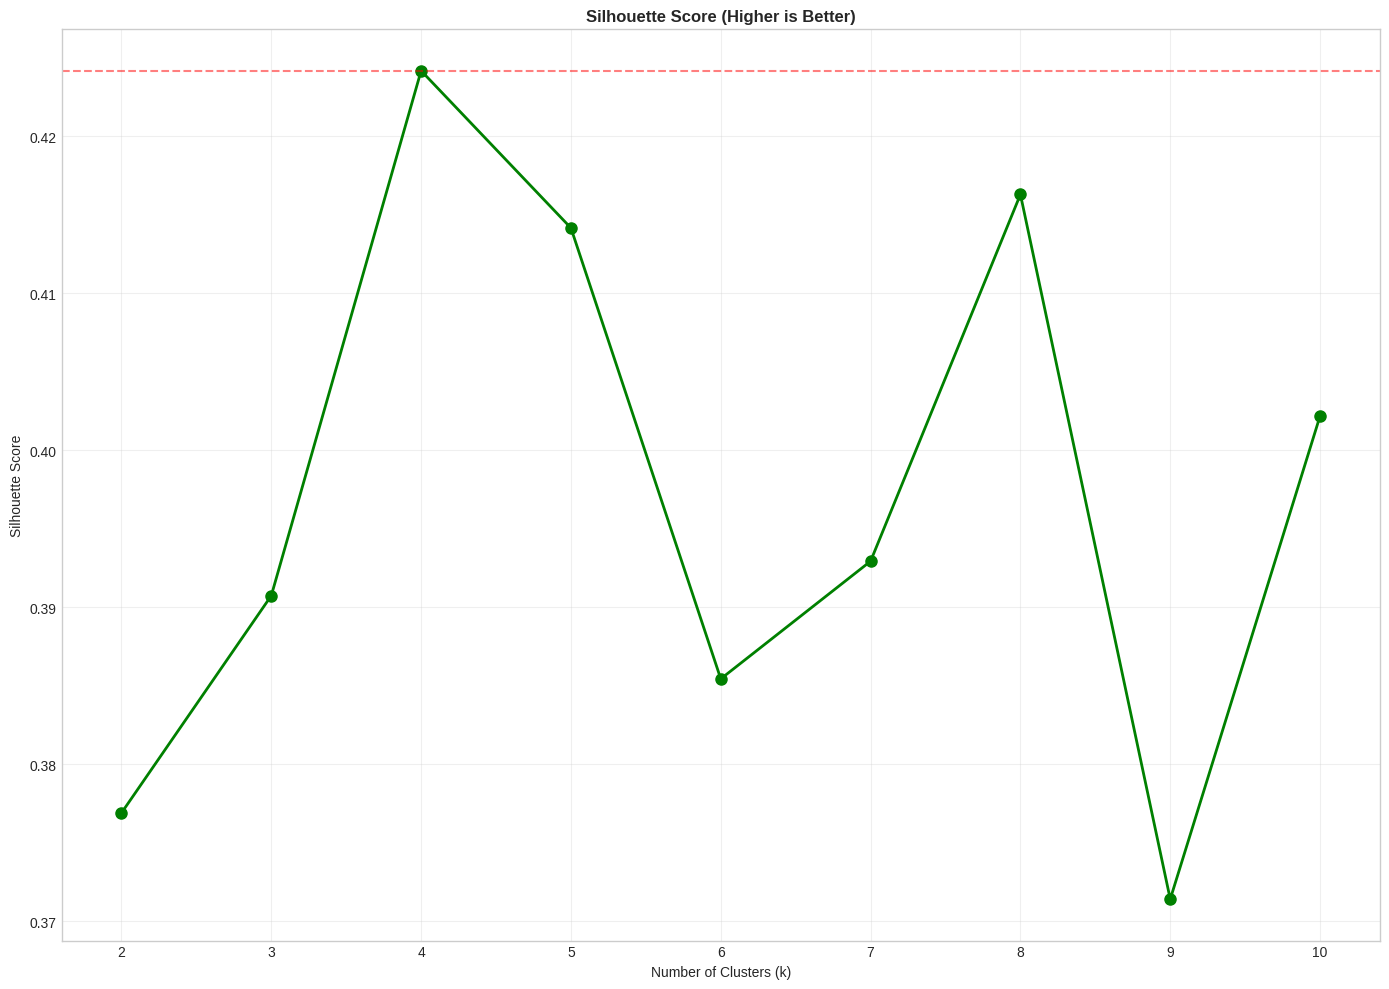

In [506]:
fig, axes = plt.subplots(figsize=(14, 10))

# Silhouette Score
axes.plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes.set_xlabel('Number of Clusters (k)')
axes.set_ylabel('Silhouette Score')
axes.set_title('Silhouette Score (Higher is Better)', fontweight='bold')
axes.axhline(y=max(silhouettes), color='r', linestyle='--', alpha=0.5)
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

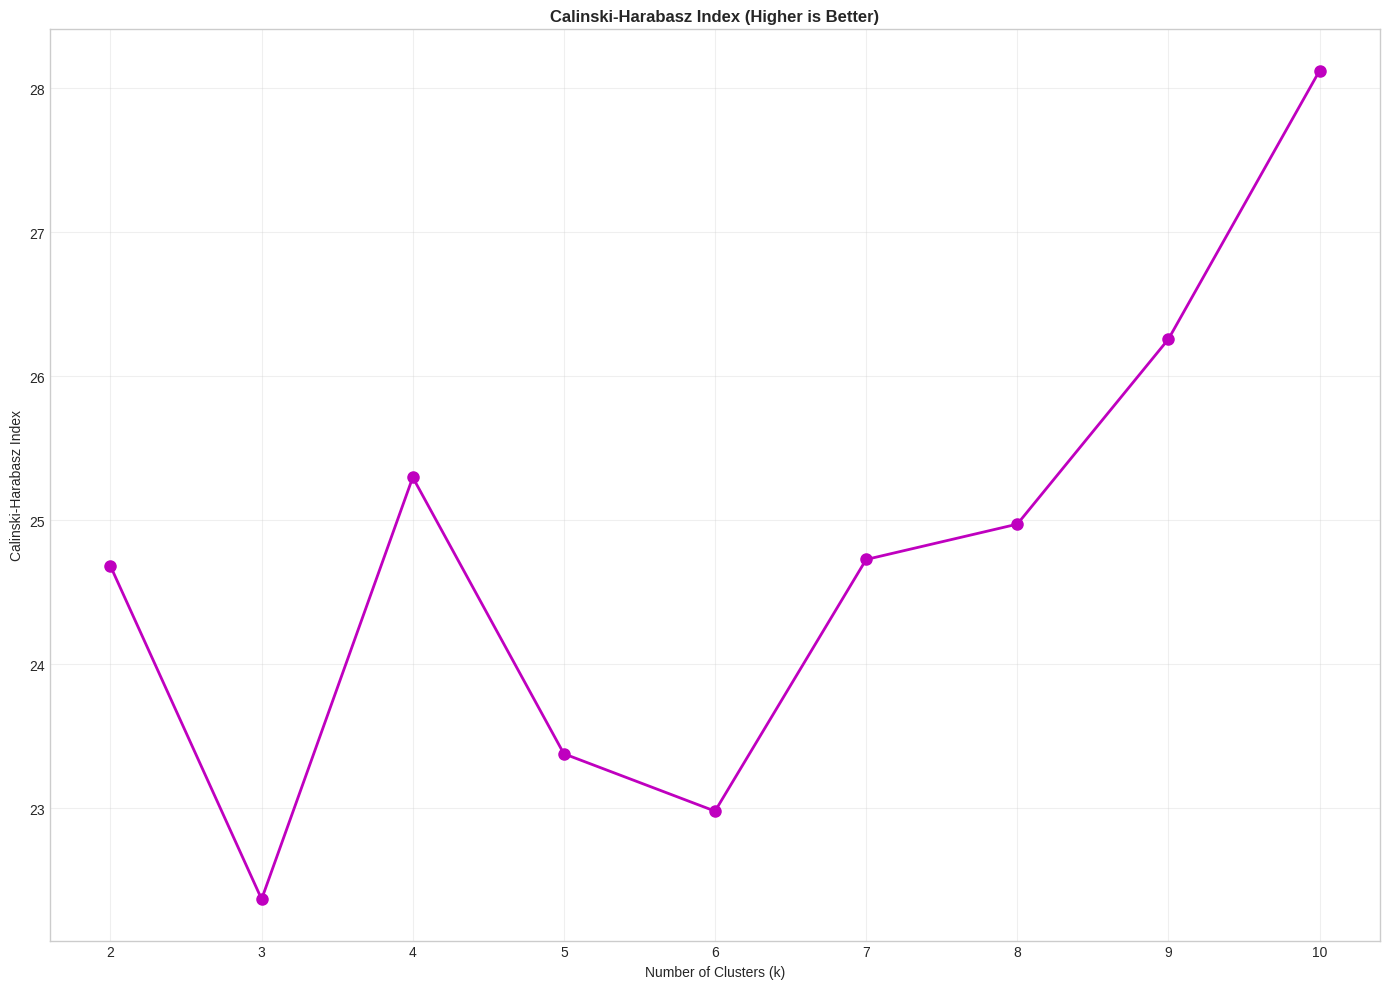

In [507]:
fig, axes = plt.subplots(figsize=(14, 10))

# Calinski-Harabasz Index
axes.plot(k_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
axes.set_xlabel('Number of Clusters (k)')
axes.set_ylabel('Calinski-Harabasz Index')
axes.set_title('Calinski-Harabasz Index (Higher is Better)', fontweight='bold')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

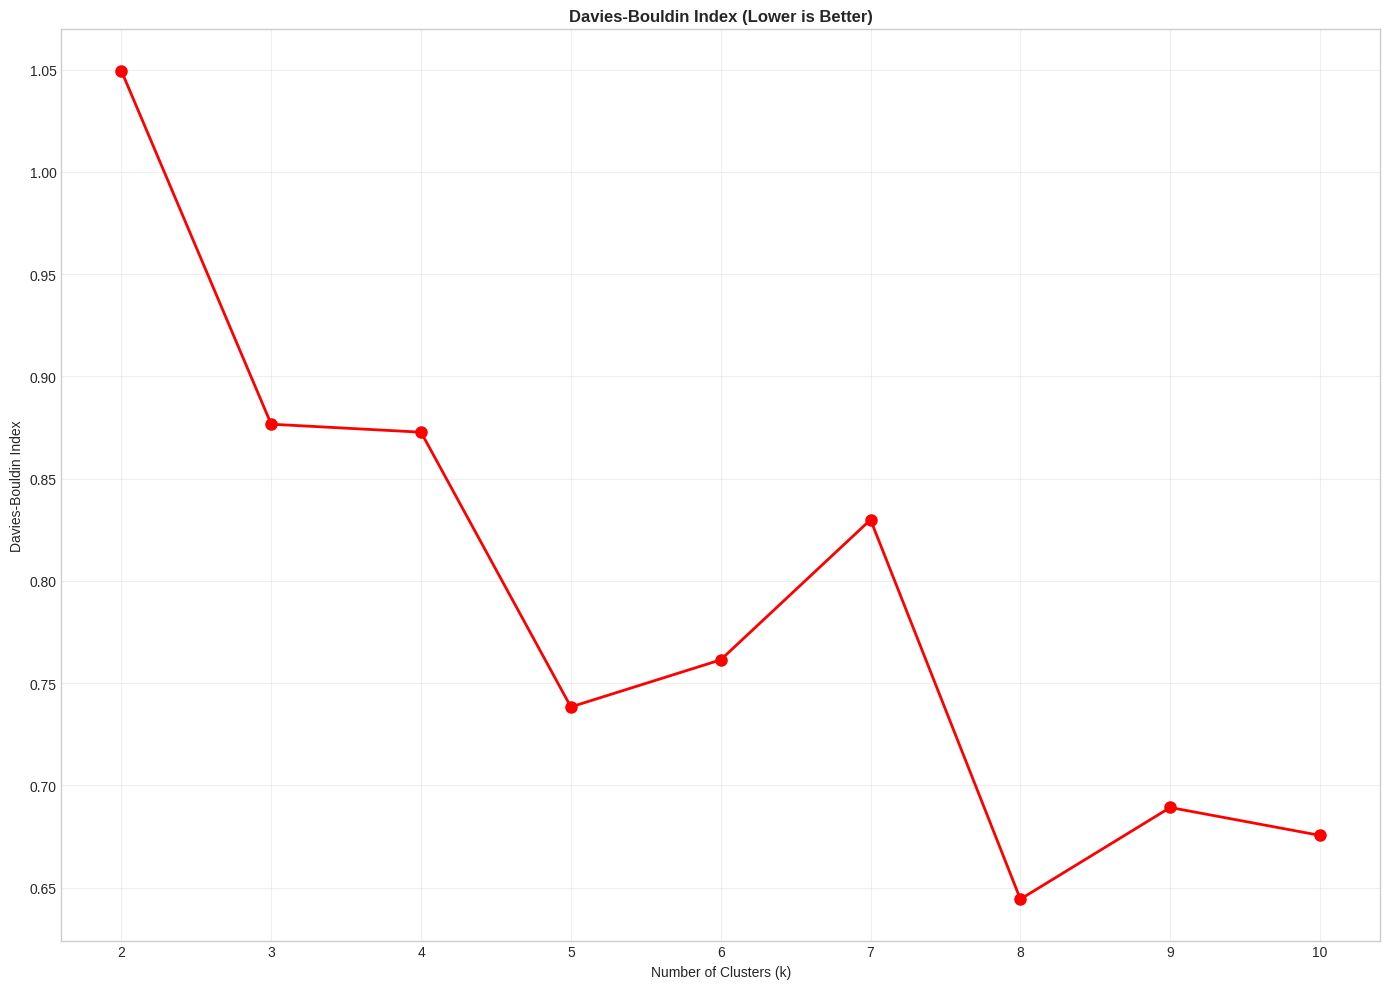

In [508]:
fig, axes = plt.subplots(figsize=(14, 10))

# Davies-Bouldin Index
axes.plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes.set_xlabel('Number of Clusters (k)')
axes.set_ylabel('Davies-Bouldin Index')
axes.set_title('Davies-Bouldin Index (Lower is Better)', fontweight='bold')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [509]:
# Determine optimal k based on metrics
best_silhouette_k = k_range[np.argmax(silhouettes)]
best_calinski_k = k_range[np.argmax(calinski_scores)]
best_davies_k = k_range[np.argmin(davies_bouldin_scores)]

In [510]:
print(f"Best k by Silhouette Score: {best_silhouette_k} (score: {max(silhouettes):.3f})")
print(f"Best k by Calinski-Harabasz: {best_calinski_k} (score: {max(calinski_scores):.1f})")
print(f"Best k by Davies-Bouldin: {best_davies_k} (score: {min(davies_bouldin_scores):.3f})")

Best k by Silhouette Score: 4 (score: 0.424)
Best k by Calinski-Harabasz: 10 (score: 28.1)
Best k by Davies-Bouldin: 8 (score: 0.644)


In [511]:
OPTIMAL_K = 5

print(f"SELECTED: k = {OPTIMAL_K}")

SELECTED: k = 5


In [512]:
# Fit KMeans
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=20, max_iter=500)
kmeans_labels = kmeans.fit_predict(X_pca)

# Add cluster labels to features dataframe
features_df['Cluster_KMeans'] = kmeans_labels

In [513]:
# Cluster statistics
for cluster in range(OPTIMAL_K):
    count = (kmeans_labels == cluster).sum()
    provinces = features_df[features_df['Cluster_KMeans'] == cluster]['Provinsi'].values
    print(f"\n   Cluster {cluster}: {count} provinces")
    print(f"   Provinces: {', '.join(provinces)}")


   Cluster 0: 9 provinces
   Provinces: Aceh, Jambi, Lampung, Nusa Tenggara Barat, Nusa Tenggara Timur, Sulawesi Tengah, Sulawesi Tenggara, Gorontalo, Sulawesi Barat

   Cluster 1: 10 provinces
   Provinces: Sumatera Utara, Sumatera Barat, Sumatera Selatan, Bengkulu, Kepulauan Bangka Belitung, Kepulauan Riau, Sulawesi Utara, Sulawesi Selatan, Maluku Utara, Papua

   Cluster 2: 7 provinces
   Provinces: Riau, Kalimantan Barat, Kalimantan Tengah, Kalimantan Selatan, Kalimantan Timur, Kalimantan Utara, Papua Barat

   Cluster 3: 7 provinces
   Provinces: DKI Jakarta, Jawa Barat, Jawa Tengah, DI Yogyakarta, Jawa Timur, Banten, Bali

   Cluster 4: 1 provinces
   Provinces: Maluku


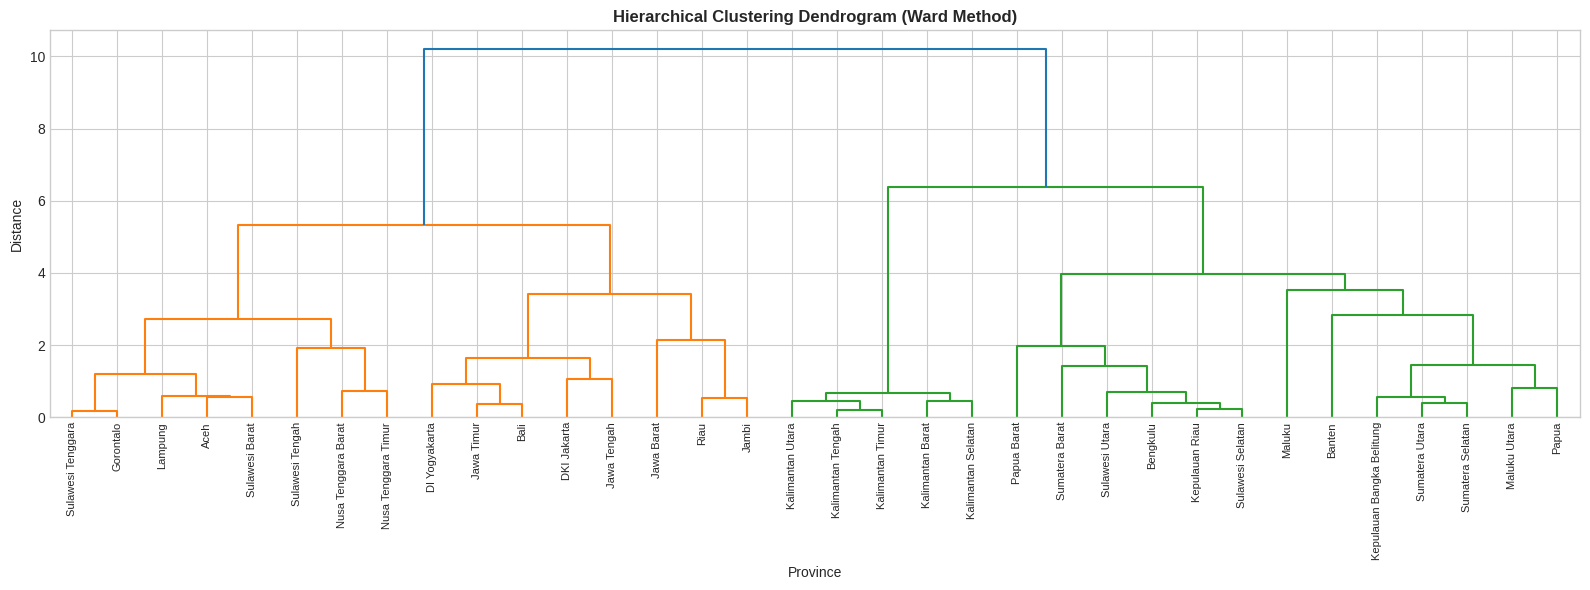

<Figure size 1200x800 with 0 Axes>

In [514]:
# Hierarchical Clustering for comparison
fig, axes = plt.subplots(figsize=(16, 6))

# Dendrogram
linkage_matrix = linkage(X_pca, method='ward')
dendrogram(linkage_matrix, labels=province_names, ax=axes, leaf_rotation=90, leaf_font_size=8)
axes.set_title('Hierarchical Clustering Dendrogram (Ward Method)', fontweight='bold')
axes.set_xlabel('Province')
axes.set_ylabel('Distance')

plt.tight_layout()
plt.show()
# Apply hierarchical clustering with k=5
hierarchical = AgglomerativeClustering(n_clusters=OPTIMAL_K, linkage='ward')
hier_labels = fcluster(
    linkage_matrix,
    t=5,
    criterion='maxclust'
)
features_df['Cluster_Hierarchical'] = hier_labels

plt.tight_layout()
plt.show()

In [515]:
hier_labels = fcluster(
    linkage_matrix,
    t=OPTIMAL_K,
    criterion='maxclust'
)

# fcluster menghasilkan label mulai dari 1 → normalisasi ke 0
features_df['Cluster_Hierarchical'] = hier_labels - 1

In [516]:
# Calculate cluster metrics
print(f"   Silhouette Score: {silhouette_score(X_pca, kmeans_labels):.3f}")
print(f"   Calinski-Harabasz Index: {calinski_harabasz_score(X_pca, kmeans_labels):.1f}")
print(f"   Davies-Bouldin Index: {davies_bouldin_score(X_pca, kmeans_labels):.3f}")

   Silhouette Score: 0.414
   Calinski-Harabasz Index: 23.4
   Davies-Bouldin Index: 0.738


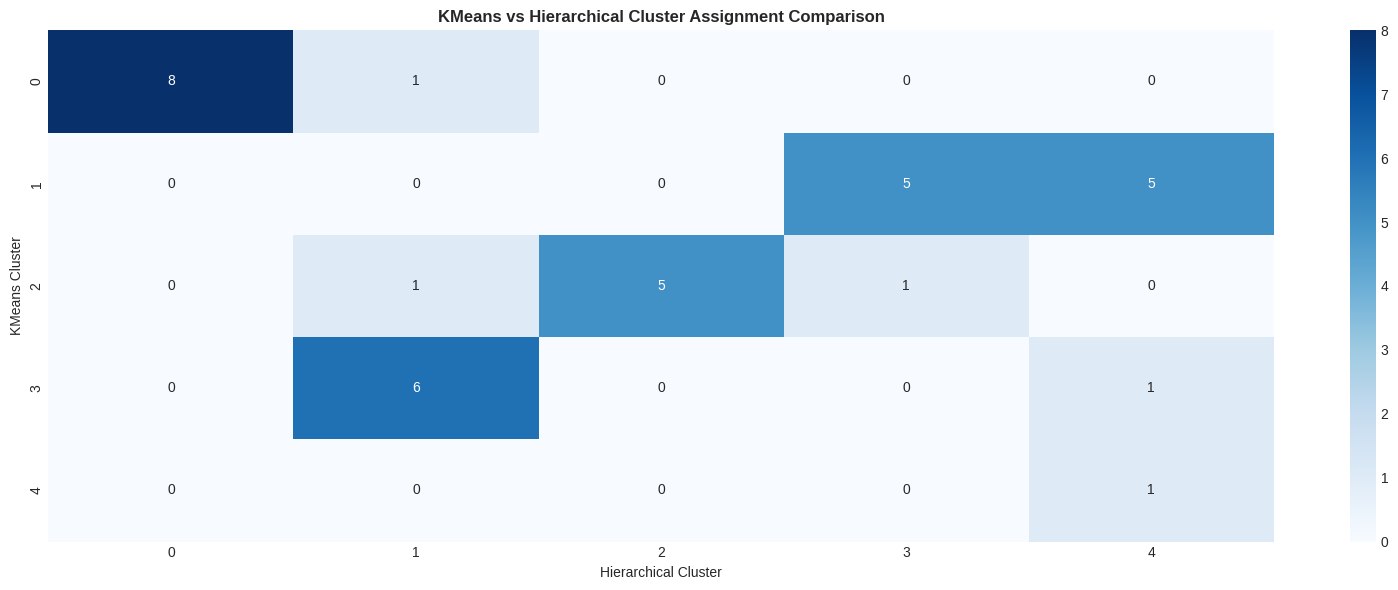

In [517]:
fig, axes = plt.subplots(figsize=(16, 6))
# Compare cluster assignments
comparison = pd.crosstab(features_df['Cluster_KMeans'], features_df['Cluster_Hierarchical'])
sns.heatmap(comparison, annot=True, fmt='d', cmap='Blues', ax=axes)
axes.set_title('KMeans vs Hierarchical Cluster Assignment Comparison', fontweight='bold')
axes.set_xlabel('Hierarchical Cluster')
axes.set_ylabel('KMeans Cluster')

plt.tight_layout()
plt.show()

In [518]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(
    features_df['Cluster_KMeans'],
    features_df['Cluster_Hierarchical']
)
print(ari)

0.5617750882501261


Perbandingan hasil KMeans dan hierarchical clustering menunjukkan tingkat konsistensi yang sedang (konsisten moderat), dengan mayoritas provinsi berada pada pasangan klaster yang sama. Perbedaan yang muncul terutama merefleksikan subdivisi internal pada beberapa klaster KMeans, yang mengindikasikan adanya zona transisi agro-ekologis

In [519]:
# Calculate cluster means for key features
cluster_means = features_df.groupby('Cluster_KMeans')[numeric_features].mean()

# Display cluster profiles
cluster_profiles = pd.DataFrame()
for cluster in range(OPTIMAL_K):
    cluster_data = features_df[features_df['Cluster_KMeans'] == cluster]
    profile = {
        'Cluster': cluster,
        'N_Provinces': len(cluster_data),
        'Mean_Rainfall': cluster_data['Mean_Annual_Rainfall'].mean(),
        'Mean_Rainy_Days': cluster_data['Mean_Rainy_Days'].mean(),
        'Rainfall_Variability': cluster_data['Rainfall_Variability'].mean(),
        'Aridity_Index': cluster_data['Aridity_Index'].mean(),
        'Soil_Volcanic': cluster_data['Soil_Volcanic'].mean(),
        'Soil_Alluvial': cluster_data['Soil_Alluvial'].mean(),
        'Soil_Organic_Peat': cluster_data['Soil_Organic_Peat'].mean(),
        'Soil_Calcareous': cluster_data['Soil_Calcareous'].mean(),
        'Dominant_Region': cluster_data['Region'].mode().values[0],
        'Climate_Zone': cluster_data['Climate_Zone'].mode().values[0]
    }
    cluster_profiles = pd.concat([cluster_profiles, pd.DataFrame([profile])], ignore_index=True)

cluster_profiles.to_string(index=False)

' Cluster  N_Provinces  Mean_Rainfall  Mean_Rainy_Days  Rainfall_Variability  Aridity_Index  Soil_Volcanic  Soil_Alluvial  Soil_Organic_Peat  Soil_Calcareous Dominant_Region     Climate_Zone\n       0            9    1587.139444       148.488889            379.714381       0.634856       0.411111       0.588889           0.411111         0.555556        Sulawesi   Tropical_Moist\n       1           10    2769.480000       197.695000            752.321841       1.107792       0.320000       0.660000           0.680000         0.320000         Sumatra     Tropical_Wet\n       2            7    2758.060000       212.661905            319.176319       1.103224       0.157143       0.542857           0.857143         0.142857      Kalimantan     Tropical_Wet\n       3            7    2016.057143       166.464286            478.695274       0.806423       0.900000       0.800000           0.100000         0.400000       Java_Bali   Tropical_Moist\n       4            1    3402.300000       2

In [520]:
for cluster in range(OPTIMAL_K):
    cluster_data = features_df[features_df['Cluster_KMeans'] == cluster]
    print(f"\nProvinces: {', '.join(cluster_data['Provinsi'].values)}")
    print(f"Climate Characteristics:")
    print(f" Mean Annual Rainfall: {cluster_data['Mean_Annual_Rainfall'].mean():.0f} mm")
    print(f" Mean Rainy Days: {cluster_data['Mean_Rainy_Days'].mean():.0f} days/year")
    print(f" Rainfall Variability: {cluster_data['Rainfall_Variability'].mean():.0f} mm (std)")
    print(f" Aridity Index: {cluster_data['Aridity_Index'].mean():.2f}")
    print(f" Dominant Climate: {cluster_data['Climate_Zone'].mode().values[0]}")
    print(f"Soil Characteristics:")
    print(f" Volcanic Soil Index: {cluster_data['Soil_Volcanic'].mean():.2f}")
    print(f" Alluvial Soil Index: {cluster_data['Soil_Alluvial'].mean():.2f}")
    print(f" Organic/Peat Index: {cluster_data['Soil_Organic_Peat'].mean():.2f}")
    print(f" Calcareous Index: {cluster_data['Soil_Calcareous'].mean():.2f}")
    print(f" Dominant Region: {cluster_data['Region'].mode().values[0]}")


Provinces: Aceh, Jambi, Lampung, Nusa Tenggara Barat, Nusa Tenggara Timur, Sulawesi Tengah, Sulawesi Tenggara, Gorontalo, Sulawesi Barat
Climate Characteristics:
 Mean Annual Rainfall: 1587 mm
 Mean Rainy Days: 148 days/year
 Rainfall Variability: 380 mm (std)
 Aridity Index: 0.63
 Dominant Climate: Tropical_Moist
Soil Characteristics:
 Volcanic Soil Index: 0.41
 Alluvial Soil Index: 0.59
 Organic/Peat Index: 0.41
 Calcareous Index: 0.56
 Dominant Region: Sulawesi

Provinces: Sumatera Utara, Sumatera Barat, Sumatera Selatan, Bengkulu, Kepulauan Bangka Belitung, Kepulauan Riau, Sulawesi Utara, Sulawesi Selatan, Maluku Utara, Papua
Climate Characteristics:
 Mean Annual Rainfall: 2769 mm
 Mean Rainy Days: 198 days/year
 Rainfall Variability: 752 mm (std)
 Aridity Index: 1.11
 Dominant Climate: Tropical_Wet
Soil Characteristics:
 Volcanic Soil Index: 0.32
 Alluvial Soil Index: 0.66
 Organic/Peat Index: 0.68
 Calcareous Index: 0.32
 Dominant Region: Sumatra

Provinces: Riau, Kalimantan Bar

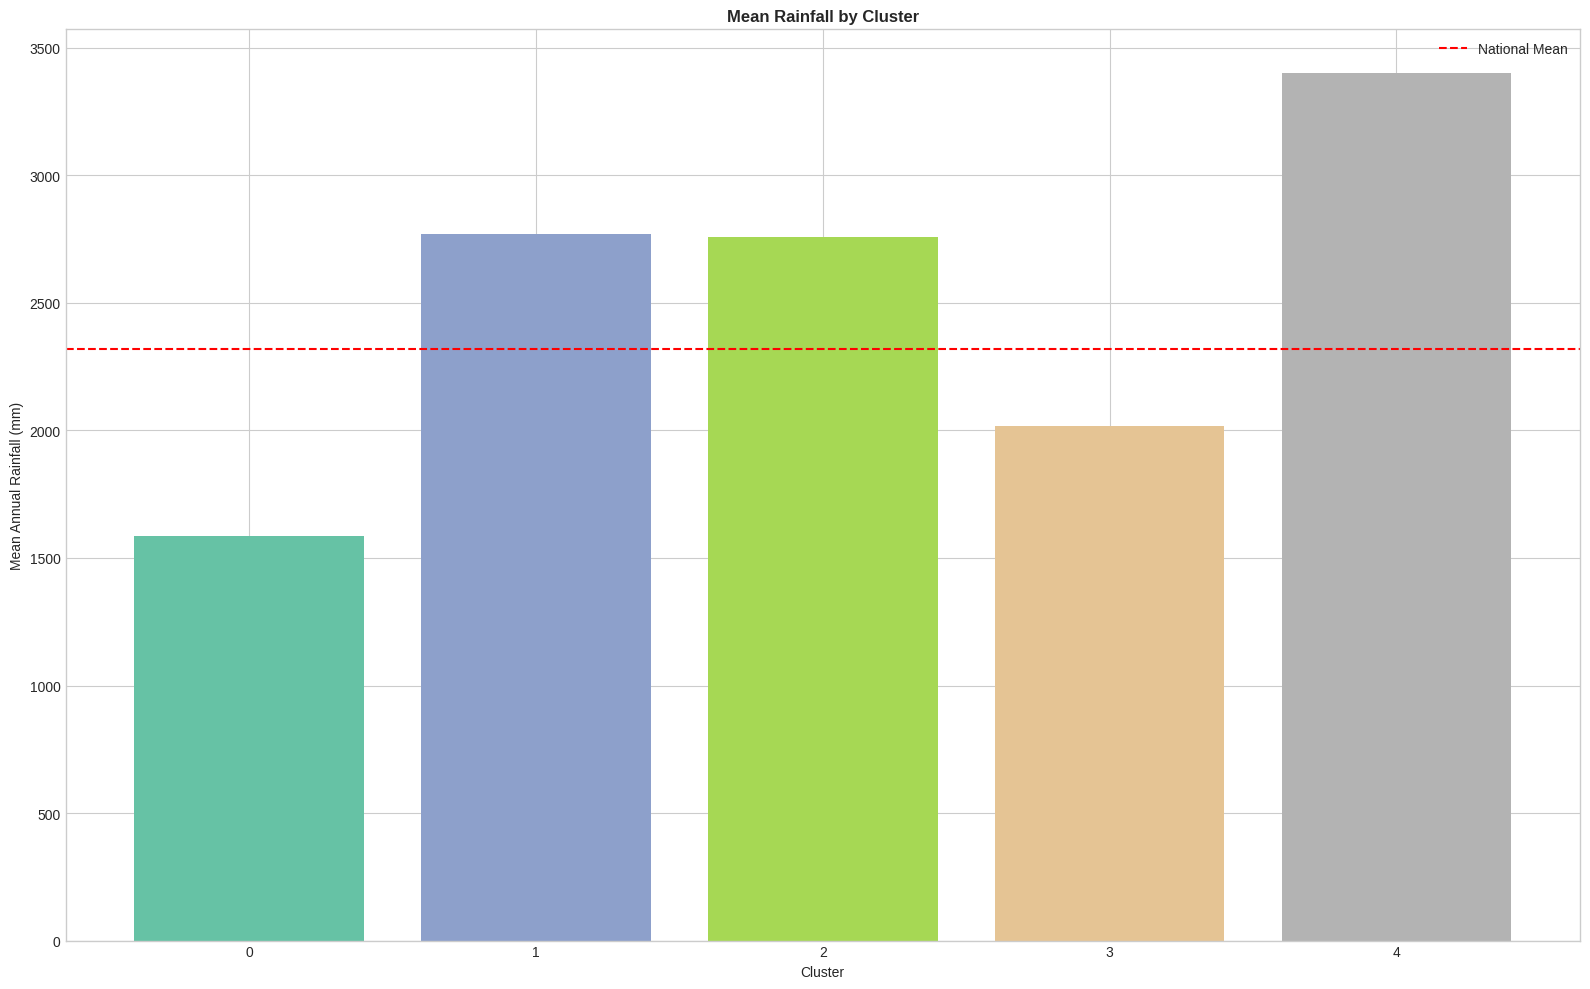

In [521]:
# Visualize Cluster Characteristics
fig, axes = plt.subplots(figsize=(16, 10))

#Rainfall by Cluster
cluster_rainfall = features_df.groupby('Cluster_KMeans')['Mean_Annual_Rainfall'].mean()
colors = plt.cm.Set2(np.linspace(0, 1, OPTIMAL_K))
bars = axes.bar(cluster_rainfall.index, cluster_rainfall.values, color=colors)
axes.set_xlabel('Cluster')
axes.set_ylabel('Mean Annual Rainfall (mm)')
axes.set_title('Mean Rainfall by Cluster', fontweight='bold')
axes.axhline(y=features_df['Mean_Annual_Rainfall'].mean(), color='red', linestyle='--', label='National Mean')
axes.legend()

plt.tight_layout()
plt.show()

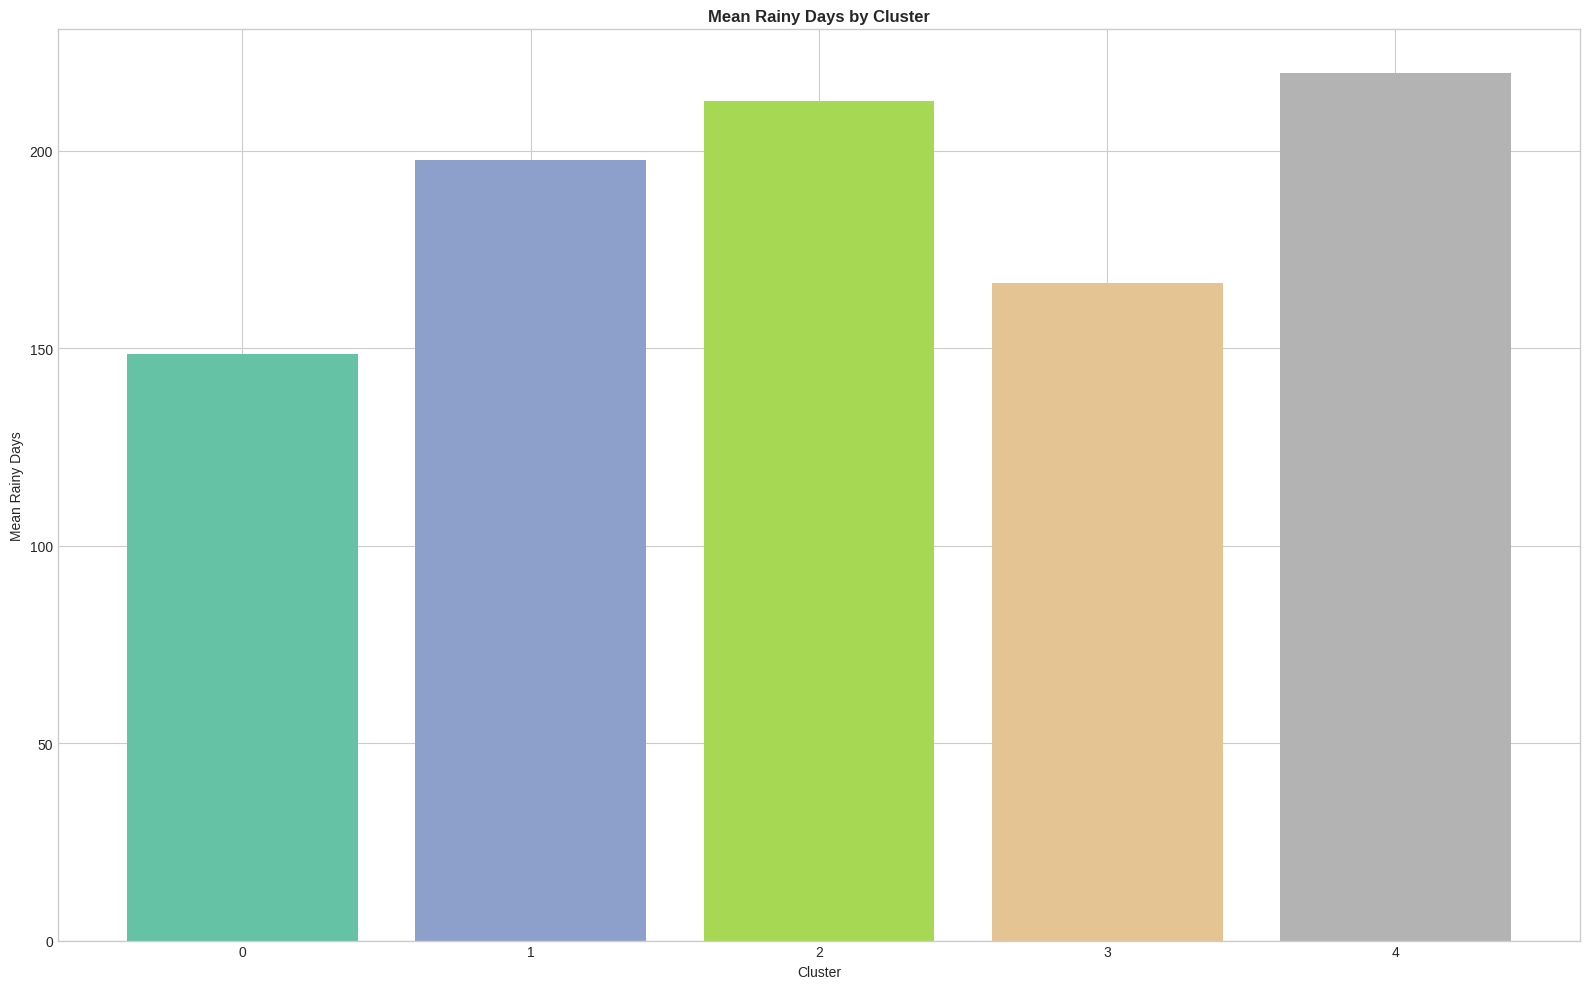

In [522]:
fig, axes = plt.subplots(figsize=(16, 10))

#Rainy Days by Cluster
cluster_rainy_days = features_df.groupby('Cluster_KMeans')['Mean_Rainy_Days'].mean()
bars = axes.bar(cluster_rainy_days.index, cluster_rainy_days.values, color=colors)
axes.set_xlabel('Cluster')
axes.set_ylabel('Mean Rainy Days')
axes.set_title('Mean Rainy Days by Cluster', fontweight='bold')

plt.tight_layout()
plt.show()

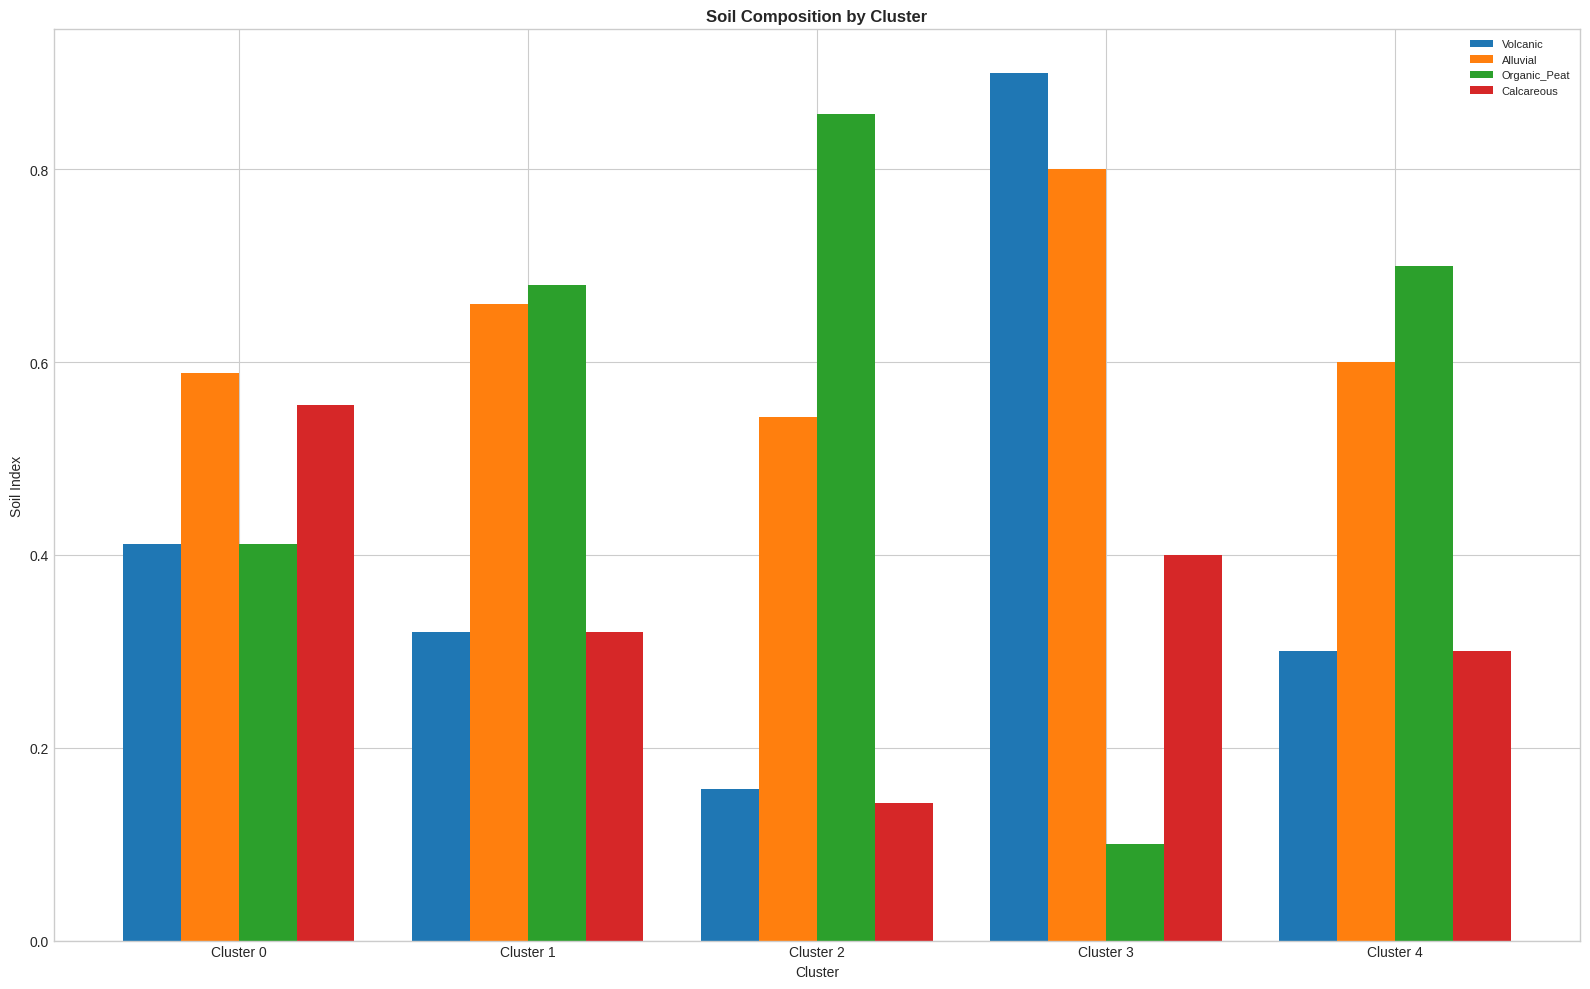

In [523]:
fig, axes = plt.subplots(figsize=(16, 10))

#Soil Composition by Cluster
soil_features = ['Soil_Volcanic', 'Soil_Alluvial', 'Soil_Organic_Peat', 'Soil_Calcareous']
soil_means = features_df.groupby('Cluster_KMeans')[soil_features].mean()
x = np.arange(OPTIMAL_K)
width = 0.2
for i, soil in enumerate(soil_features):
    axes.bar(x + i*width, soil_means[soil], width, label=soil.replace('Soil_', ''))
axes.set_xlabel('Cluster')
axes.set_ylabel('Soil Index')
axes.set_title('Soil Composition by Cluster', fontweight='bold')
axes.set_xticks(x + width*1.5)
axes.set_xticklabels([f'Cluster {i}' for i in range(OPTIMAL_K)])
axes.legend(fontsize=8)

plt.tight_layout()
plt.show()

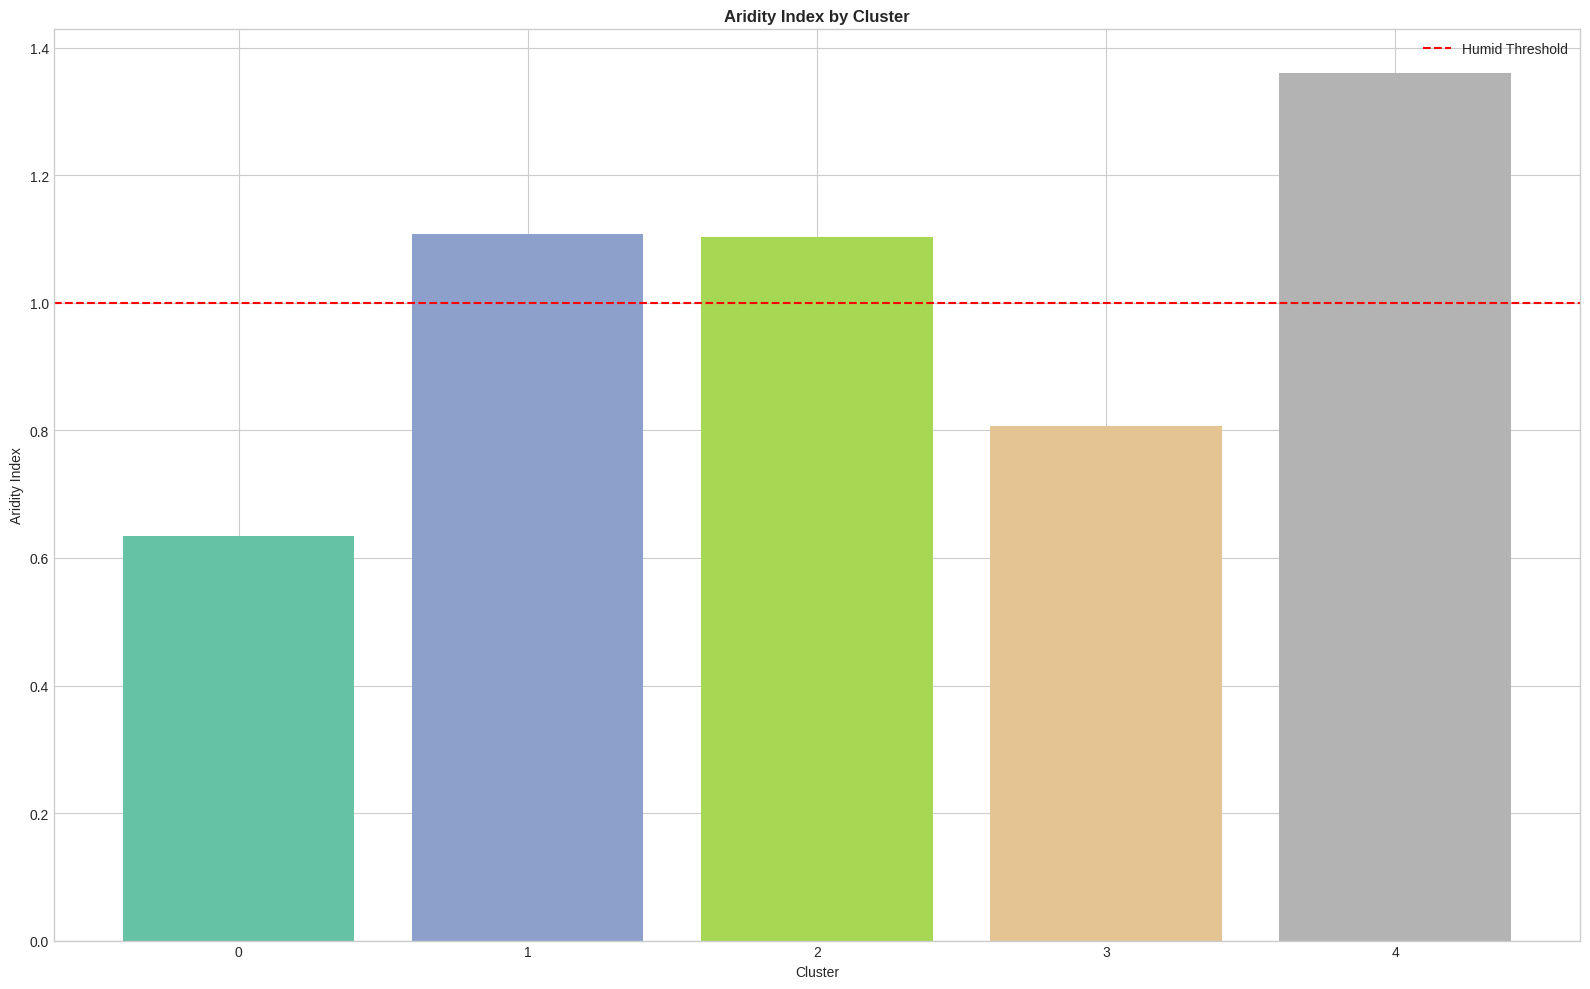

In [524]:
fig, axes = plt.subplots(figsize=(16, 10))

#Aridity Index by Cluster
cluster_aridity = features_df.groupby('Cluster_KMeans')['Aridity_Index'].mean()
bars = axes.bar(cluster_aridity.index, cluster_aridity.values, color=colors)
axes.set_xlabel('Cluster')
axes.set_ylabel('Aridity Index')
axes.set_title('Aridity Index by Cluster', fontweight='bold')
axes.axhline(y=1.0, color='red', linestyle='--', label='Humid Threshold')
axes.legend()

plt.tight_layout()
plt.show()

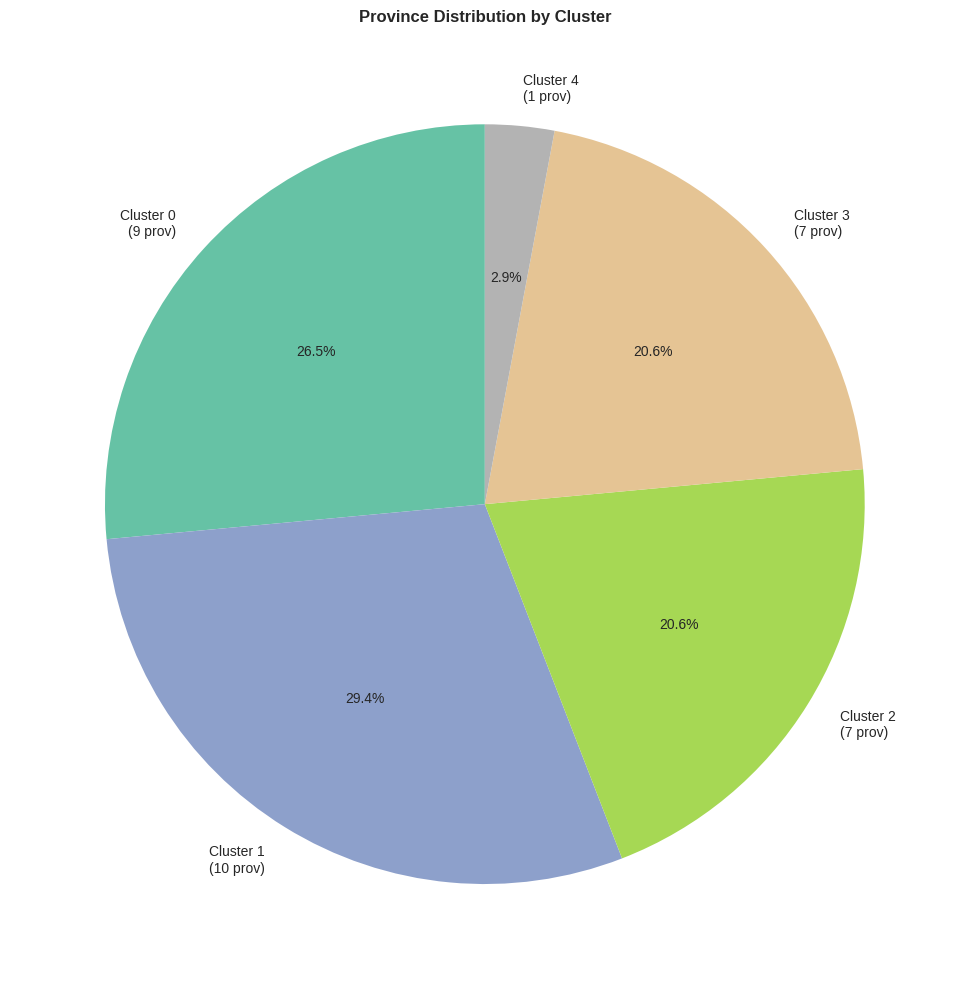

In [525]:
fig, axes = plt.subplots(figsize=(16, 10))

#Provinces per Cluster
cluster_counts = features_df['Cluster_KMeans'].value_counts().sort_index()
axes.pie(cluster_counts.values, labels=[f'Cluster {i}\n({v} prov)' for i, v in cluster_counts.items()],
        autopct='%1.1f%%', colors=colors, startangle=90)
axes.set_title('Province Distribution by Cluster', fontweight='bold')

plt.tight_layout()
plt.show()

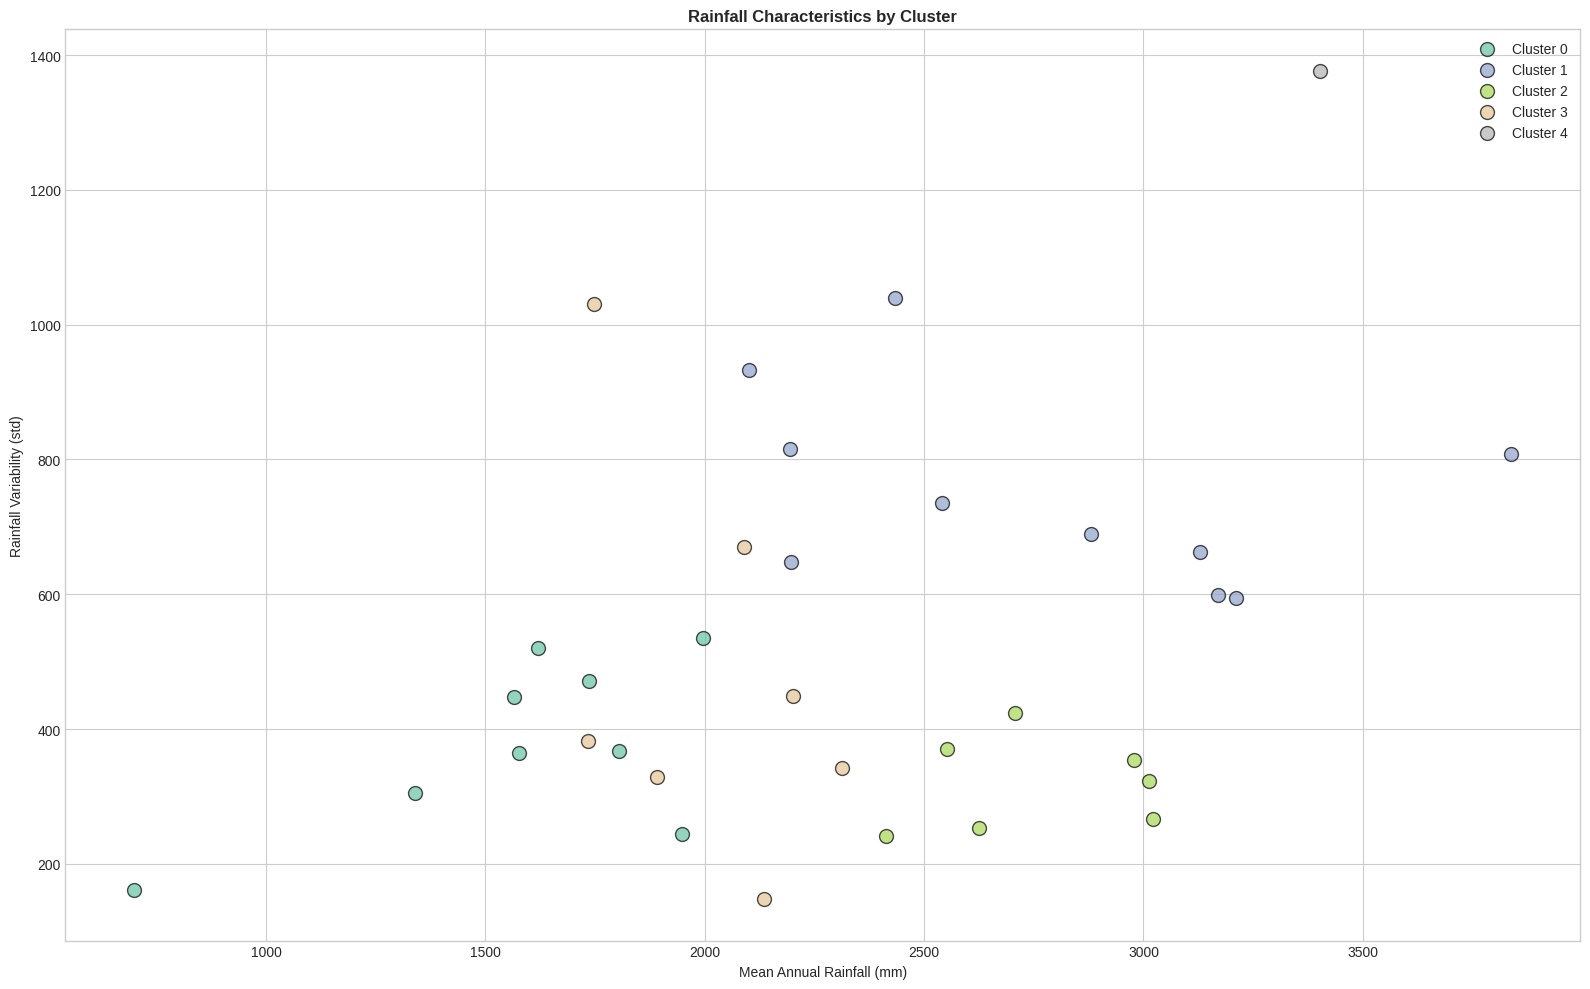

In [526]:
fig, axes = plt.subplots(figsize=(16, 10))

#Rainfall Variability vs Mean Rainfall by Cluster
for cluster in range(OPTIMAL_K):
    cluster_data = features_df[features_df['Cluster_KMeans'] == cluster]
    axes.scatter(cluster_data['Mean_Annual_Rainfall'], cluster_data['Rainfall_Variability'],
                c=[colors[cluster]], label=f'Cluster {cluster}', s=100, alpha=0.7, edgecolors='black')
axes.set_xlabel('Mean Annual Rainfall (mm)')
axes.set_ylabel('Rainfall Variability (std)')
axes.set_title('Rainfall Characteristics by Cluster', fontweight='bold')
axes.legend()

plt.tight_layout()
plt.show()

In [527]:
# Definisi kelompok fungsional karbohidrat
carb_functional_groups = {
    'wetland_cereals': {
        'name': 'Wetland Cereals',
        'crops': ['Padi (Oryza sativa)'],
        'characteristics': 'Membutuhkan air tinggi, sawah tergenang',
        'water_requirement': 'Tinggi (>1500mm/tahun)',
        'soil_preference': ['Alluvial', 'Volcanic', 'Paddy soil'],
        'ideal_conditions': 'Lahan basah dengan irigasi baik'
    },
    'dryland_cereals': {
        'name': 'Dryland Cereals', 
        'crops': ['Jagung (Zea mays)', 'Sorgum (Sorghum bicolor)', 'Jewawut (Setaria italica)'],
        'characteristics': 'Tahan kering, adaptif terhadap variasi curah hujan',
        'water_requirement': 'Rendah-Sedang (600-1200mm/tahun)',
        'soil_preference': ['Volcanic', 'Calcareous', 'Sandy loam'],
        'ideal_conditions': 'Lahan kering dengan drainase baik'
    },
    'root_tubers_humid': {
        'name': 'Root & Tubers (Humid)',
        'crops': ['Singkong (Manihot esculenta)', 'Talas (Colocasia esculenta)', 
                  'Ubi Jalar (Ipomoea batatas)', 'Kentang (Solanum tuberosum)'],
        'characteristics': 'Fleksibel, adaptif berbagai kondisi lembab',
        'water_requirement': 'Sedang (1000-2000mm/tahun)',
        'soil_preference': ['Volcanic', 'Alluvial', 'Organic'],
        'ideal_conditions': 'Lahan lembab dengan tanah gembur'
    },
    'palms_starch_trees': {
        'name': 'Palms & Starch Trees',
        'crops': ['Sagu (Metroxylon sagu)', 'Aren (Arenga pinnata)', 'Enau'],
        'characteristics': 'Butuh air tinggi, habitat rawa dan lahan basah',
        'water_requirement': 'Sangat Tinggi (>2500mm/tahun)',
        'soil_preference': ['Organic/Peat', 'Swamp', 'Alluvial wetland'],
        'ideal_conditions': 'Lahan rawa, gambut, atau pesisir berair'
    },
    'drought_resilient_roots': {
        'name': 'Drought-Resilient Roots',
        'crops': ['Ganyong (Canna edulis)', 'Porang (Amorphophallus muelleri)', 
                  'Garut (Maranta arundinacea)', 'Suweg (Amorphophallus paeoniifolius)',
                  'Uwi/Gadung (Dioscorea spp.)'],
        'characteristics': 'Tahan kering, cocok untuk lahan marginal',
        'water_requirement': 'Rendah (<1000mm/tahun)',
        'soil_preference': ['Calcareous', 'Sandy', 'Marginal soil'],
        'ideal_conditions': 'Lahan marginal, kering, atau hutan'
    }
}

In [528]:

# Mapping cluster ke kelompok fungsional yang direkomendasikan
cluster_to_functional_groups = {
    0: {
        'name': 'Dry–Moist Calcareous Sulawesi Zone',
        'primary': ['dryland_cereals'],
        'diversification': ['drought_resilient_roots'],
        'rationale': (
            'Curah hujan relatif rendah (≈1587 mm) dengan indeks ariditas 0.63 '
            'dan dominasi tanah kapur Sulawesi, sesuai untuk serealia tahan kering '
            'dan umbi marginal.'
        )
    },
    1: {
        'name': 'Humid Peat–Alluvial Sumatra Zone',
        'primary': ['palms_starch_trees', 'wetland_cereals'],
        'diversification': ['root_tubers_humid'],
        'rationale': (
            'Curah hujan tinggi (≈2770 mm) dengan tanah gambut dan aluvial dominan, '
            'mendukung sagu dan padi lahan basah.'
        )
    },
    2: {
        'name': 'Extreme Peat Kalimantan Wet Zone',
        'primary': ['palms_starch_trees'],
        'diversification': ['root_tubers_humid'],
        'rationale': (
            'Rainy days sangat tinggi (≈213 hari) dan indeks gambut ekstrem (0.86), '
            'membatasi serealia dan memprioritaskan tanaman pati rawa.'
        )
    },
    3: {
        'name': 'Volcanic Intensive Java–Bali Zone',
        'primary': ['wetland_cereals', 'dryland_cereals'],
        'diversification': ['root_tubers_humid'],
        'rationale': (
            'Tanah vulkanik dan aluvial sangat subur dengan curah hujan sedang, '
            'ideal untuk sistem padi–jagung intensif dan umbi dataran tinggi.'
        )
    },
    4: {
        'name': 'Equatorial Humid Core (Maluku–Papua)',
        'primary': ['palms_starch_trees'],
        'diversification': ['root_tubers_humid'],
        'rationale': (
            'Curah hujan dan hari hujan ekstrem dengan variabilitas tinggi, '
            'membatasi serealia dan menjadikan sagu sebagai pangan strategis.'
        )
    }
}

In [529]:
crop_mapping = {
    0: {
        'name': 'Dry–Moist Calcareous Sulawesi Zone',
        'characteristics': (
            'Moderate–low rainfall (~1587 mm), aridity index 0.63, '
            'calcareous soils dominant, Sulawesi region'
        ),
        'functional_groups': {
            'primary': ['Dryland Cereals'],
            'diversification': ['Drought-Resilient Roots']
        },
        'primary_crops': [
            'Maize (Zea mays)',
            'Sorghum (Sorghum bicolor)',
            'Foxtail millet (Setaria italica)'
        ],
        'diversification_crops': [
            'Porang (Amorphophallus muelleri)',
            'Ganyong (Canna edulis)',
            'Cassava (drought-tolerant varieties)'
        ],
        'rationale': '''
        - Curah hujan relatif rendah (~1587 mm) dan indeks ariditas 0.63
        - Dominasi tanah kapur (0.56) membatasi padi sawah
        - Jagung dan sorgum adaptif pada lahan kering Sulawesi
        - Umbi tahan kering penting untuk ketahanan pangan wilayah
        '''
    },

    1: {
        'name': 'Humid Peat–Alluvial Sumatra Zone',
        'characteristics': (
            'High rainfall (~2769 mm), high peat and alluvial soils, '
            'Sumatra region'
        ),
        'functional_groups': {
            'primary': ['Palms & Starch Trees', 'Wetland Cereals'],
            'diversification': ['Root & Tubers (Humid)']
        },
        'primary_crops': [
            'Sago (Metroxylon sagu)',
            'Rice (wetland varieties)'
        ],
        'diversification_crops': [
            'Cassava (Manihot esculenta)',
            'Taro (Colocasia esculenta)',
            'Sweet Potato (Ipomoea batatas)'
        ],
        'rationale': '''
        - Curah hujan tinggi (~2769 mm) dan hari hujan ~198
        - Indeks tanah gambut (0.68) dan aluvial (0.66) tinggi
        - Sagu unggul di lahan gambut, padi di lahan basah aluvial
        - Umbi tropis sebagai diversifikasi adaptif
        '''
    },

    2: {
        'name': 'Extreme Peat Kalimantan Wet Zone',
        'characteristics': (
            'Very high rainfall (~2758 mm), very high peat index (0.86), '
            'Kalimantan region'
        ),
        'functional_groups': {
            'primary': ['Palms & Starch Trees'],
            'diversification': ['Root & Tubers (Humid)']
        },
        'primary_crops': [
            'Sago (Metroxylon sagu)'
        ],
        'diversification_crops': [
            'Taro (Colocasia esculenta)',
            'Wild yams (Dioscorea spp.)'
        ],
        'rationale': '''
        - Hari hujan sangat tinggi (~213 hari/tahun)
        - Tanah gambut ekstrem (0.86) membatasi serealia
        - Sagu merupakan tanaman pati paling adaptif
        - Umbi rawa menjadi pelengkap pangan lokal
        '''
    },

    3: {
        'name': 'Volcanic Intensive Java–Bali Zone',
        'characteristics': (
            'Moderate rainfall (~2016 mm), very high volcanic (0.90) '
            'and alluvial soils (0.80), Java–Bali region'
        ),
        'functional_groups': {
            'primary': ['Wetland Cereals', 'Dryland Cereals'],
            'diversification': ['Root & Tubers (Humid)']
        },
        'primary_crops': [
            'Rice (Oryza sativa)',
            'Maize (Zea mays)'
        ],
        'diversification_crops': [
            'Potato (Solanum tuberosum)',
            'Sweet Potato (Ipomoea batatas)',
            'Cassava (Manihot esculenta)'
        ],
        'rationale': '''
        - Tanah vulkanik paling subur (0.90) di Indonesia
        - Infrastruktur irigasi mendukung padi sawah intensif
        - Jagung cocok pada lahan kering antar-musim
        - Umbi dataran tinggi relevan untuk diversifikasi
        '''
    },

    4: {
        'name': 'Equatorial Humid Core (Maluku–Papua)',
        'characteristics': (
            'Extreme rainfall (~3402 mm), very high rainy days (~220), '
            'equatorial humid climate'
        ),
        'functional_groups': {
            'primary': ['Palms & Starch Trees'],
            'diversification': ['Root & Tubers (Humid)']
        },
        'primary_crops': [
            'Sago (Metroxylon sagu)'
        ],
        'diversification_crops': [
            'Taro (Colocasia esculenta)',
            'Sweet Potato (Ipomoea batatas)'
        ],
        'rationale': '''
        - Curah hujan ekstrem dan variabilitas tinggi
        - Risiko tinggi untuk serealia
        - Sagu merupakan pangan paling stabil secara ekologis
        - Umbi tropis berperan sebagai pangan pendukung
        '''
    }
}

In [530]:
# Display functional groups overview
for group_id, group_info in carb_functional_groups.items():
    print(f"\n {group_info['name']}")
    print(f"   Crops: {', '.join(group_info['crops'])}")
    print(f"   Karakteristik: {group_info['characteristics']}")
    print(f"   Kebutuhan Air: {group_info['water_requirement']}")
    print(f"   Tipe Tanah: {', '.join(group_info['soil_preference'])}")


 Wetland Cereals
   Crops: Padi (Oryza sativa)
   Karakteristik: Membutuhkan air tinggi, sawah tergenang
   Kebutuhan Air: Tinggi (>1500mm/tahun)
   Tipe Tanah: Alluvial, Volcanic, Paddy soil

 Dryland Cereals
   Crops: Jagung (Zea mays), Sorgum (Sorghum bicolor), Jewawut (Setaria italica)
   Karakteristik: Tahan kering, adaptif terhadap variasi curah hujan
   Kebutuhan Air: Rendah-Sedang (600-1200mm/tahun)
   Tipe Tanah: Volcanic, Calcareous, Sandy loam

 Root & Tubers (Humid)
   Crops: Singkong (Manihot esculenta), Talas (Colocasia esculenta), Ubi Jalar (Ipomoea batatas), Kentang (Solanum tuberosum)
   Karakteristik: Fleksibel, adaptif berbagai kondisi lembab
   Kebutuhan Air: Sedang (1000-2000mm/tahun)
   Tipe Tanah: Volcanic, Alluvial, Organic

 Palms & Starch Trees
   Crops: Sagu (Metroxylon sagu), Aren (Arenga pinnata), Enau
   Karakteristik: Butuh air tinggi, habitat rawa dan lahan basah
   Kebutuhan Air: Sangat Tinggi (>2500mm/tahun)
   Tipe Tanah: Organic/Peat, Swamp, Alluvia

In [531]:
# Display crop mapping with functional groups
for cluster, info in crop_mapping.items():
    provinces = features_df[features_df['Cluster_KMeans'] == cluster]['Provinsi'].values
    print(f"CLUSTER {cluster}: {info['name']}")
    print(f"\nProvinces: {', '.join(provinces)}")
    print(f"Characteristics: {info['characteristics']}")
    
    print(f"\n KELOMPOK FUNGSIONAL:")
    print(f"   Primary: {', '.join(info['functional_groups']['primary'])}")
    print(f"   Diversifikasi: {', '.join(info['functional_groups']['diversification'])}")
    
    print(f"\n PRIMARY CROPS:")
    for crop in info['primary_crops']:
        print(f"  {crop}")
    print(f"\n DIVERSIFICATION CROPS:")
    for crop in info['diversification_crops']:
        print(f"  {crop}")
    print(f"\nRATIONALE:{info['rationale']}")

CLUSTER 0: Dry–Moist Calcareous Sulawesi Zone

Provinces: Aceh, Jambi, Lampung, Nusa Tenggara Barat, Nusa Tenggara Timur, Sulawesi Tengah, Sulawesi Tenggara, Gorontalo, Sulawesi Barat
Characteristics: Moderate–low rainfall (~1587 mm), aridity index 0.63, calcareous soils dominant, Sulawesi region

 KELOMPOK FUNGSIONAL:
   Primary: Dryland Cereals
   Diversifikasi: Drought-Resilient Roots

 PRIMARY CROPS:
  Maize (Zea mays)
  Sorghum (Sorghum bicolor)
  Foxtail millet (Setaria italica)

 DIVERSIFICATION CROPS:
  Porang (Amorphophallus muelleri)
  Ganyong (Canna edulis)
  Cassava (drought-tolerant varieties)

RATIONALE:
        - Curah hujan relatif rendah (~1587 mm) dan indeks ariditas 0.63
        - Dominasi tanah kapur (0.56) membatasi padi sawah
        - Jagung dan sorgum adaptif pada lahan kering Sulawesi
        - Umbi tahan kering penting untuk ketahanan pangan wilayah
        
CLUSTER 1: Humid Peat–Alluvial Sumatra Zone

Provinces: Sumatera Utara, Sumatera Barat, Sumatera Selata

In [532]:
# Add cluster names and crop recommendations to the dataframe
cluster_names = {
    0: 'Dry–Moist Calcareous Sulawesi Zone',
    1: 'Humid Peat–Alluvial Sumatra Zone',
    2: 'Extreme Peat Kalimantan Wet Zone',
    3: 'Volcanic Intensive Java–Bali Zone',
    4: 'Equatorial Humid Core (Maluku–Papua)'
}


# Mapping berdasarkan kelompok fungsional karbohidrat
primary_crops_map = {
    0: 'Jagung, Sorgum, Jewawut',
    1: 'Sagu, Padi',
    2: 'Sagu',
    3: 'Padi, Jagung',
    4: 'Sagu'
}


diversification_map = {
    0: 'Porang, Ganyong, Singkong',
    1: 'Singkong, Talas, Ubi Jalar',
    2: 'Talas, Uwi',
    3: 'Kentang, Ubi Jalar, Singkong',
    4: 'Talas, Ubi Jalar'
}


# Mapping kelompok fungsional utama per cluster
functional_group_primary_map = {
    0: 'Dryland Cereals',
    1: 'Palms & Starch Trees, Wetland Cereals',
    2: 'Palms & Starch Trees',
    3: 'Wetland Cereals, Dryland Cereals',
    4: 'Palms & Starch Trees'
}


functional_group_diversification_map = {
    0: 'Drought-Resilient Roots',
    1: 'Root & Tubers (Humid)',
    2: 'Root & Tubers (Humid)',
    3: 'Root & Tubers (Humid)',
    4: 'Root & Tubers (Humid)'
}

In [533]:
print(cluster_names)

{0: 'Dry–Moist Calcareous Sulawesi Zone', 1: 'Humid Peat–Alluvial Sumatra Zone', 2: 'Extreme Peat Kalimantan Wet Zone', 3: 'Volcanic Intensive Java–Bali Zone', 4: 'Equatorial Humid Core (Maluku–Papua)'}


In [534]:
n_clusters = len(cluster_names)  # = 5

summary_table = (
    features_df
    .groupby('Cluster_KMeans')
    .agg(
        Provinces=('Provinsi', 'count'),
        Avg_Rainfall_mm=('Mean_Annual_Rainfall', 'mean')
    )
    .reset_index()
)

summary_table['Cluster'] = summary_table['Cluster_KMeans'].apply(lambda x: f'C{x}')
summary_table['Name'] = summary_table['Cluster_KMeans'].map(cluster_names)
summary_table['Primary_Crop'] = summary_table['Cluster_KMeans'].map(primary_crops_map)

summary_table = summary_table[
    ['Cluster', 'Name', 'Provinces', 'Avg_Rainfall_mm', 'Primary_Crop']
]

summary_table

,Cluster,Name,Provinces,Avg_Rainfall_mm,Primary_Crop
0,C0,Dry–Moist Calcareous Sulawesi Zone,9,1587.139444,"Jagung, Sorgum, Jewawut"
1,C1,Humid Peat–Alluvial Sumatra Zone,10,2769.480000,"Sagu, Padi"
2,C2,Extreme Peat Kalimantan Wet Zone,7,2758.060000,Sagu
3,C3,Volcanic Intensive Java–Bali Zone,7,2016.057143,"Padi, Jagung"
4,C4,Equatorial Humid Core (Maluku–Papua),1,3402.300000,Sagu


In [535]:
features_df['Cluster_KMeans'] = features_df['Cluster_KMeans'].astype(int)

In [536]:
features_df['Cluster_Name'] = features_df['Cluster_KMeans'].map(cluster_names)
features_df['Primary_Crops'] = features_df['Cluster_KMeans'].map(primary_crops_map)
features_df['Diversification_Crops'] = features_df['Cluster_KMeans'].map(diversification_map)
features_df['Functional_Group_Primary'] = features_df['Cluster_KMeans'].map(functional_group_primary_map)
features_df['Functional_Group_Diversification'] = features_df['Cluster_KMeans'].map(functional_group_diversification_map)

In [537]:
features_df[
    ['Cluster_KMeans', 'Cluster_Name',
     'Functional_Group_Primary', 'Primary_Crops']
].drop_duplicates().sort_values('Cluster_KMeans')


,Cluster_KMeans,Cluster_Name,Functional_Group_Primary,Primary_Crops
0,0,Dry–Moist Calcareous Sulawesi Zone,Dryland Cereals,"Jagung, Sorgum, Jewawut"
1,1,Humid Peat–Alluvial Sumatra Zone,"Palms & Starch Trees, Wetland Cereals","Sagu, Padi"
3,2,Extreme Peat Kalimantan Wet Zone,Palms & Starch Trees,Sagu
10,3,Volcanic Intensive Java–Bali Zone,"Wetland Cereals, Dryland Cereals","Padi, Jagung"
30,4,Equatorial Humid Core (Maluku–Papua),Palms & Starch Trees,Sagu


In [538]:
final_output = features_df[['Provinsi', 'Region', 'Cluster_KMeans', 'Cluster_Name', 
                             'Mean_Annual_Rainfall', 'Climate_Zone', 
                             'Functional_Group_Primary', 'Primary_Crops', 
                             'Functional_Group_Diversification', 'Diversification_Crops']].copy()
final_output = final_output.sort_values('Cluster_KMeans')
final_output

,Provinsi,Region,Cluster_KMeans,Cluster_Name,Mean_Annual_Rainfall,Climate_Zone,Functional_Group_Primary,Primary_Crops,Functional_Group_Diversification,Diversification_Crops
0,Aceh,Sumatra,0,Dry–Moist Calcareous Sulawesi Zone,1565.800,Tropical_Moist,Dryland Cereals,"Jagung, Sorgum, Jewawut",Drought-Resilient Roots,"Porang, Ganyong, Singkong"
4,Jambi,Sumatra,0,Dry–Moist Calcareous Sulawesi Zone,1947.700,Tropical_Moist,Dryland Cereals,"Jagung, Sorgum, Jewawut",Drought-Resilient Roots,"Porang, Ganyong, Singkong"
7,Lampung,Sumatra,0,Dry–Moist Calcareous Sulawesi Zone,1804.060,Tropical_Moist,Dryland Cereals,"Jagung, Sorgum, Jewawut",Drought-Resilient Roots,"Porang, Ganyong, Singkong"
28,Gorontalo,Sulawesi,0,Dry–Moist Calcareous Sulawesi Zone,1619.380,Tropical_Moist,Dryland Cereals,"Jagung, Sorgum, Jewawut",Drought-Resilient Roots,"Porang, Ganyong, Singkong"
25,Sulawesi Tengah,Sulawesi,0,Dry–Moist Calcareous Sulawesi Zone,699.740,Semi_Arid,Dryland Cereals,"Jagung, Sorgum, Jewawut",Drought-Resilient Roots,"Porang, Ganyong, Singkong"
27,Sulawesi Tenggara,Sulawesi,0,Dry–Moist Calcareous Sulawesi Zone,1995.750,Tropical_Moist,Dryland Cereals,"Jagung, Sorgum, Jewawut",Drought-Resilient Roots,"Porang, Ganyong, Singkong"
18,Nusa Tenggara Timur,Nusa_Tenggara,0,Dry–Moist Calcareous Sulawesi Zone,1576.120,Tropical_Seasonal,Dryland Cereals,"Jagung, Sorgum, Jewawut",Drought-Resilient Roots,"Porang, Ganyong, Singkong"
17,Nusa Tenggara Barat,Nusa_Tenggara,0,Dry–Moist Calcareous Sulawesi Zone,1736.925,Tropical_Moist,Dryland Cereals,"Jagung, Sorgum, Jewawut",Drought-Resilient Roots,"Porang, Ganyong, Singkong"
29,Sulawesi Barat,Sulawesi,0,Dry–Moist Calcareous Sulawesi Zone,1338.780,Tropical_Seasonal,Dryland Cereals,"Jagung, Sorgum, Jewawut",Drought-Resilient Roots,"Porang, Ganyong, Singkong"
24,Sulawesi Utara,Sulawesi,1,Humid Peat–Alluvial Sumatra Zone,2881.160,Tropical_Wet,"Palms & Starch Trees, Wetland Cereals","Sagu, Padi",Root & Tubers (Humid),"Singkong, Talas, Ubi Jalar"


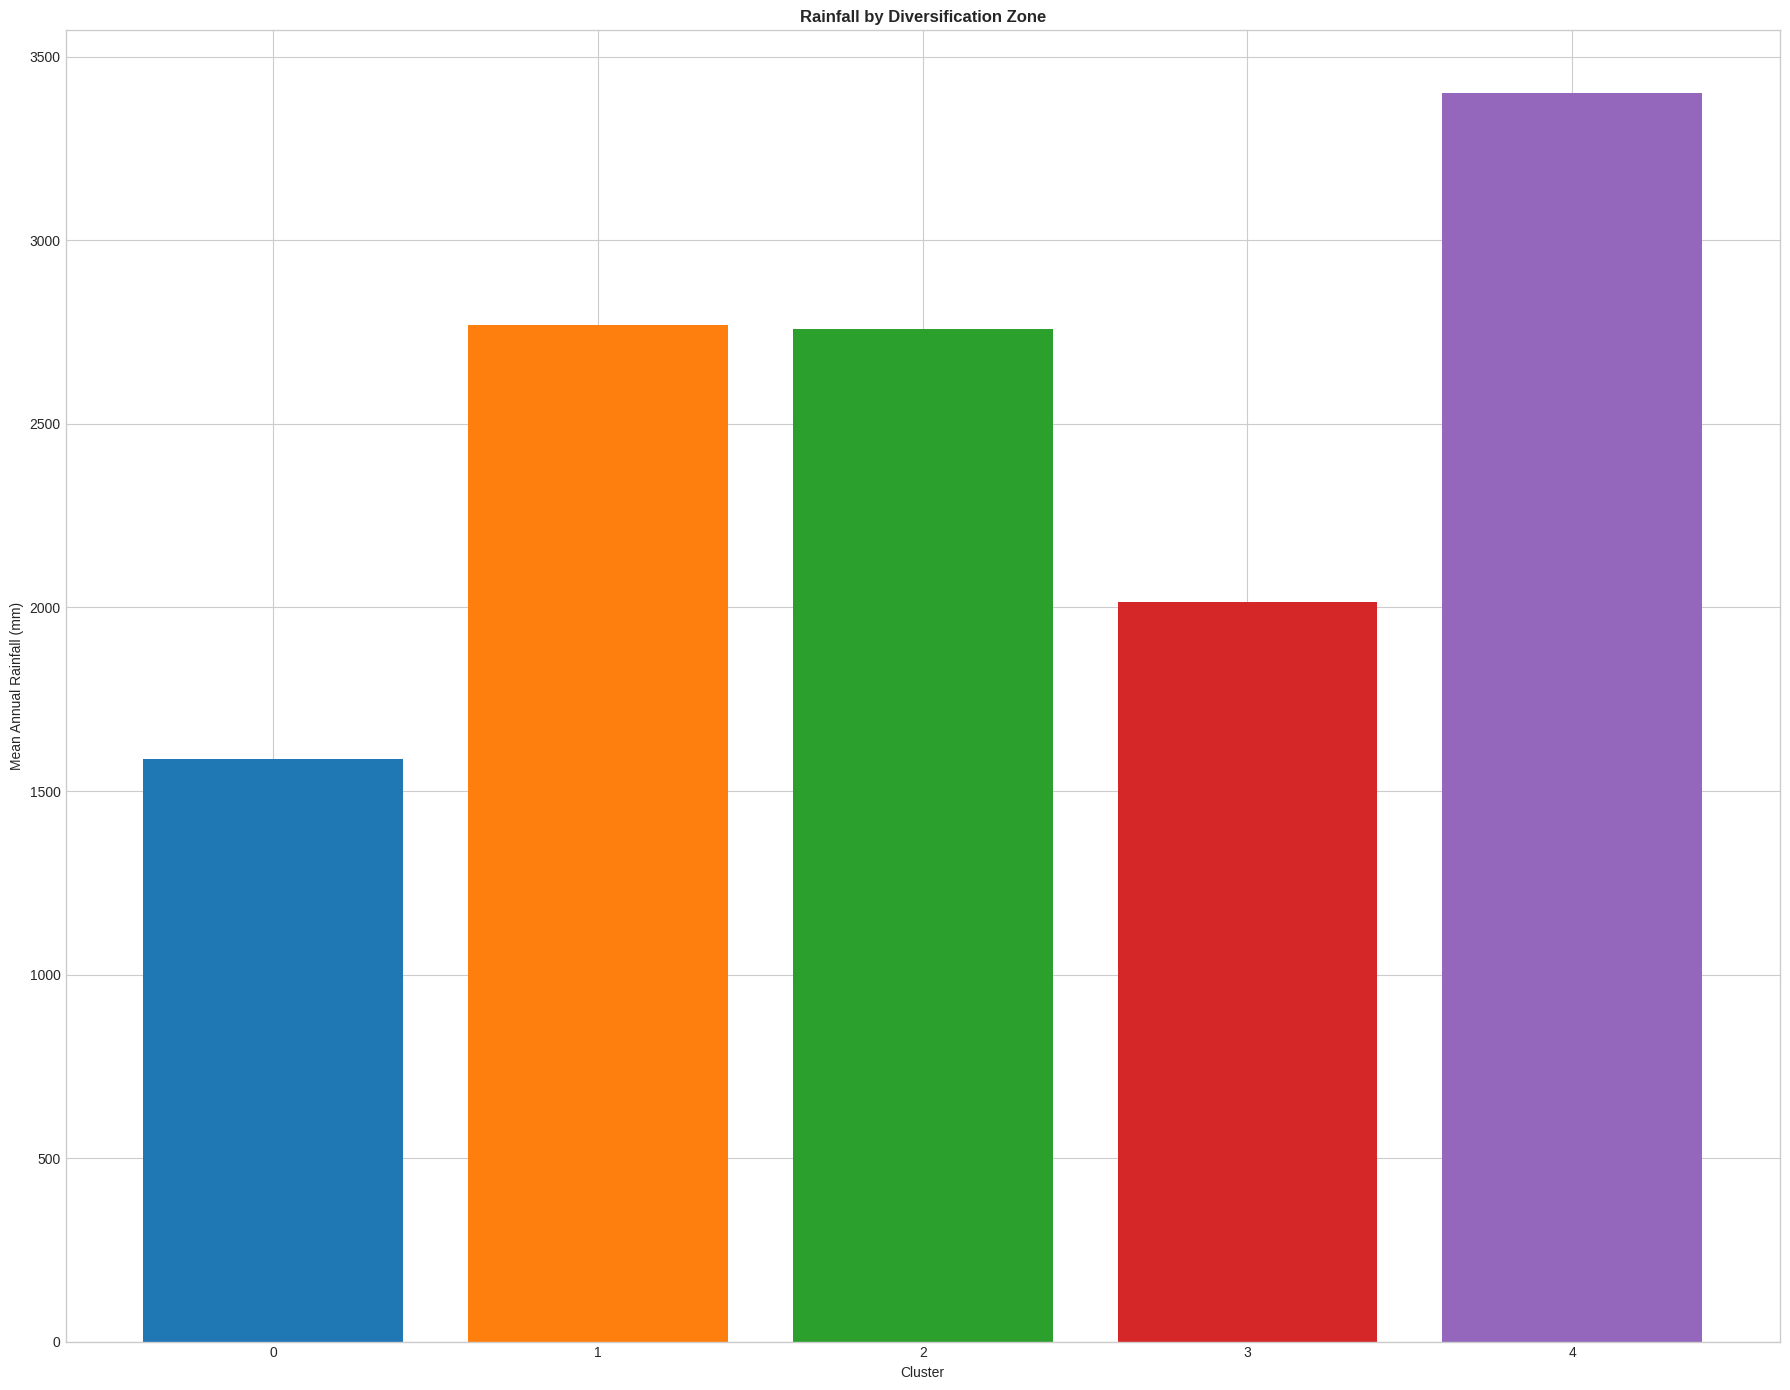

In [539]:
# Create comprehensive summary visualization
plt.figure(figsize=(18, 14))

# Define cluster colors
cluster_colors = {
    0: '#2ecc71',  # Green - Sumatra
    1: '#e74c3c',  # Red - Java-Bali
    2: '#3498db',  # Blue - Kalimantan
    3: '#f39c12',  # Orange - Mixed Islands
    4: '#9b59b6'   # Purple - Dry Eastern
}

#Cluster Summary Bar Chart
cluster_summary = features_df.groupby('Cluster_KMeans').agg({
    'Mean_Annual_Rainfall': 'mean',
    'Provinsi': 'count'
}).reset_index()

plt.bar(
    cluster_summary['Cluster_KMeans'],
    cluster_summary['Mean_Annual_Rainfall'],
    color=plt.cm.tab10(cluster_summary['Cluster_KMeans'])
)

plt.xlabel('Cluster')
plt.ylabel('Mean Annual Rainfall (mm)')
plt.title('Rainfall by Diversification Zone', fontweight='bold')
plt.tight_layout()
plt.show()

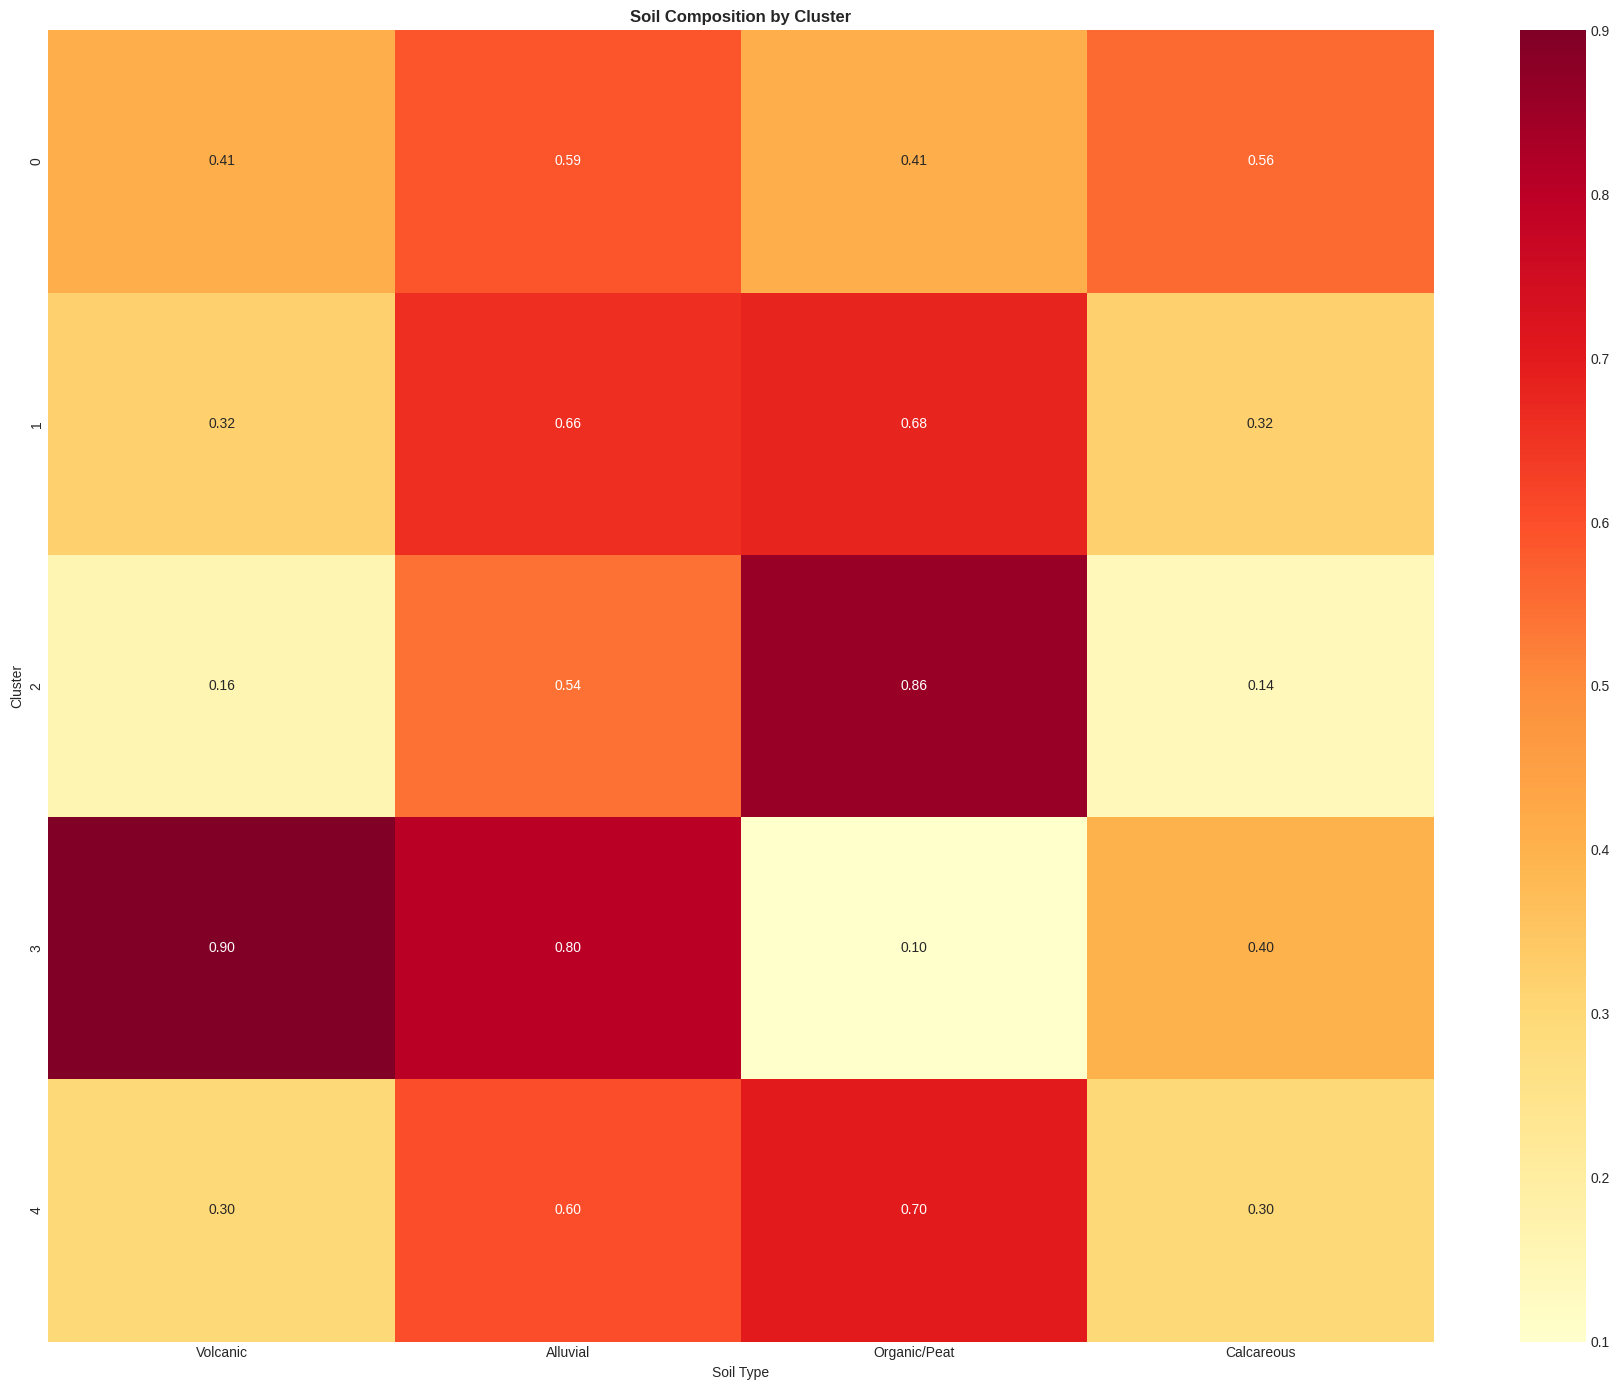

In [540]:
plt.figure(figsize=(18, 14))
#Soil Composition Heatmap
soil_cols = ['Soil_Volcanic', 'Soil_Alluvial', 'Soil_Organic_Peat', 'Soil_Calcareous']
soil_matrix = features_df.groupby('Cluster_KMeans')[soil_cols].mean()
soil_matrix.columns = ['Volcanic', 'Alluvial', 'Organic/Peat', 'Calcareous']

sns.heatmap(
    soil_matrix,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd'
)

plt.title('Soil Composition by Cluster', fontweight='bold')
plt.xlabel('Soil Type')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

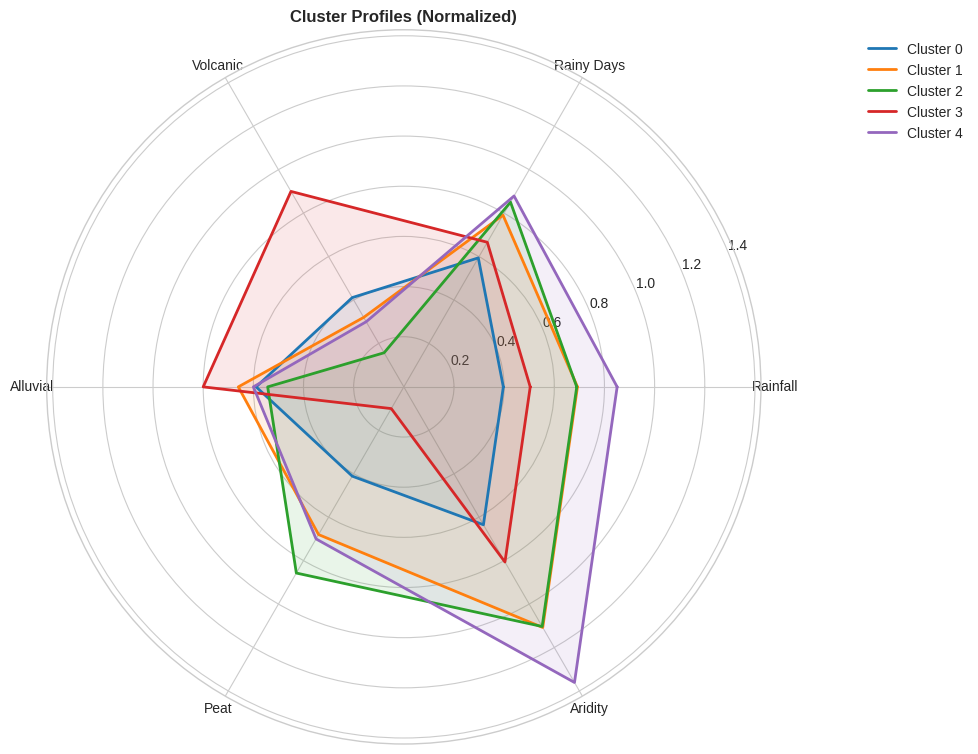

In [541]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

categories = ['Rainfall', 'Rainy Days', 'Volcanic', 'Alluvial', 'Peat', 'Aridity']
N = len(categories)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

colors = plt.cm.tab10(np.arange(OPTIMAL_K))

for cluster in range(OPTIMAL_K):
    cluster_data = features_df[features_df['Cluster_KMeans'] == cluster]
    values = [
        cluster_data['Mean_Annual_Rainfall'].mean() / 4000,
        cluster_data['Mean_Rainy_Days'].mean() / 250,
        cluster_data['Soil_Volcanic'].mean(),
        cluster_data['Soil_Alluvial'].mean(),
        cluster_data['Soil_Organic_Peat'].mean(),
        cluster_data['Aridity_Index'].mean()
    ]
    values += values[:1]

    ax.plot(angles, values, linewidth=2, color=colors[cluster],
            label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.1, color=colors[cluster])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title('Cluster Profiles (Normalized)', fontweight='bold')
ax.legend(bbox_to_anchor=(1.3, 1))

plt.tight_layout()
plt.show()

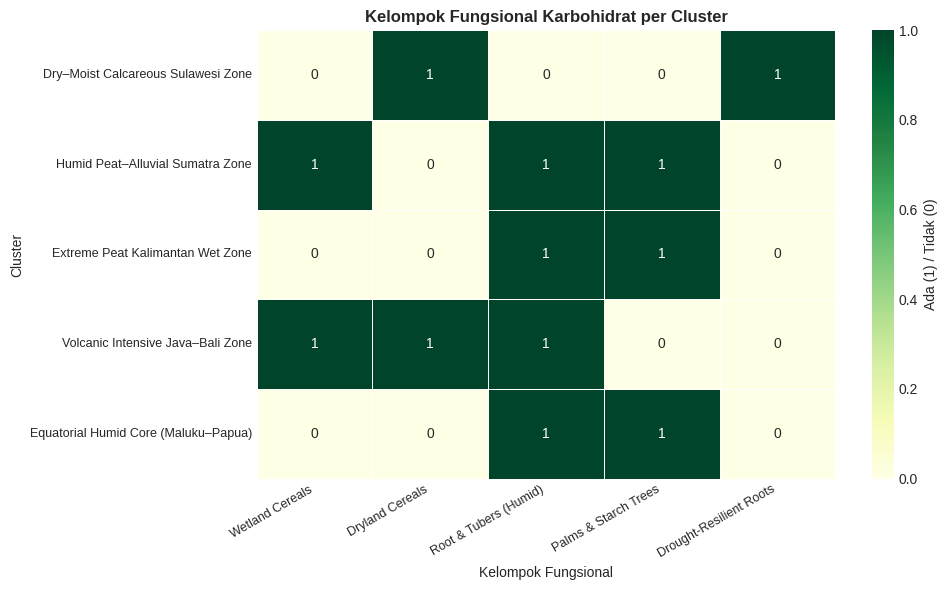

In [542]:
plt.figure(figsize=(10, 6))

# Daftar kelompok fungsional karbohidrat
functional_groups = [
    'Wetland Cereals',
    'Dryland Cereals',
    'Root & Tubers (Humid)',
    'Palms & Starch Trees',
    'Drought-Resilient Roots'
]

# Ambil mapping kelompok fungsional dari crop_mapping
cluster_names_list = [crop_mapping[i]['name'] for i in crop_mapping]
cluster_fg_matrix = []
for i in crop_mapping:
    fg_present = []
    fg_dict = crop_mapping[i].get('functional_groups', {})
    # Gabungkan primary & diversification
    fg_all = fg_dict.get('primary', []) + fg_dict.get('diversification', [])
    for fg in functional_groups:
        fg_present.append(1 if fg in fg_all else 0)
    cluster_fg_matrix.append(fg_present)

fg_df = pd.DataFrame(cluster_fg_matrix, columns=functional_groups, index=cluster_names_list)

sns.heatmap(
    fg_df,
    annot=True,
    cmap='YlGn',
    cbar_kws={'label': 'Ada (1) / Tidak (0)'},
    linewidths=0.5,
    linecolor='white'
)
plt.title('Kelompok Fungsional Karbohidrat per Cluster', fontweight='bold', fontsize=12)
plt.yticks(rotation=0, fontsize=9)
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.xlabel('Kelompok Fungsional')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

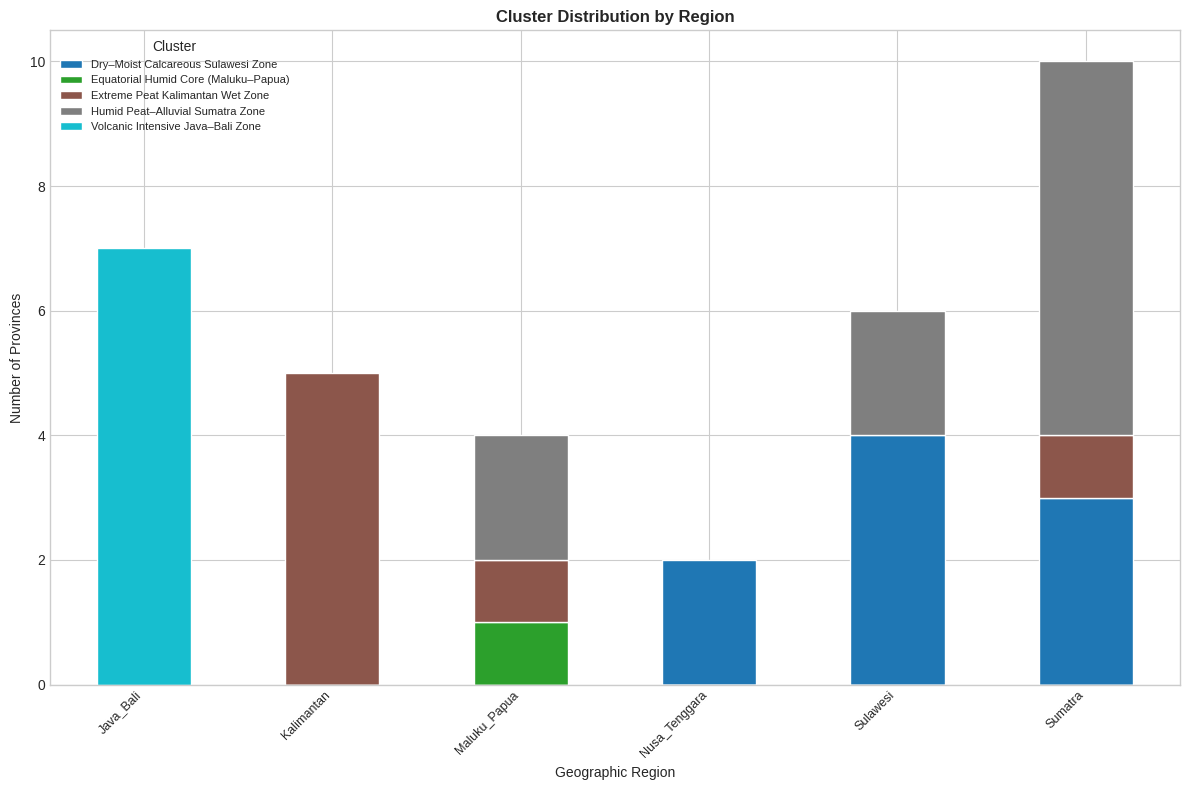

In [543]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

region_cluster = pd.crosstab(
    features_df['Region'],
    features_df['Cluster_Name']
)

region_cluster.plot(
    kind='bar',
    stacked=True,
    edgecolor='white',
    colormap='tab10'
)

plt.xlabel('Geographic Region')
plt.ylabel('Number of Provinces')
plt.title('Cluster Distribution by Region', fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.legend(title='Cluster', fontsize=8)

plt.tight_layout()
plt.show()

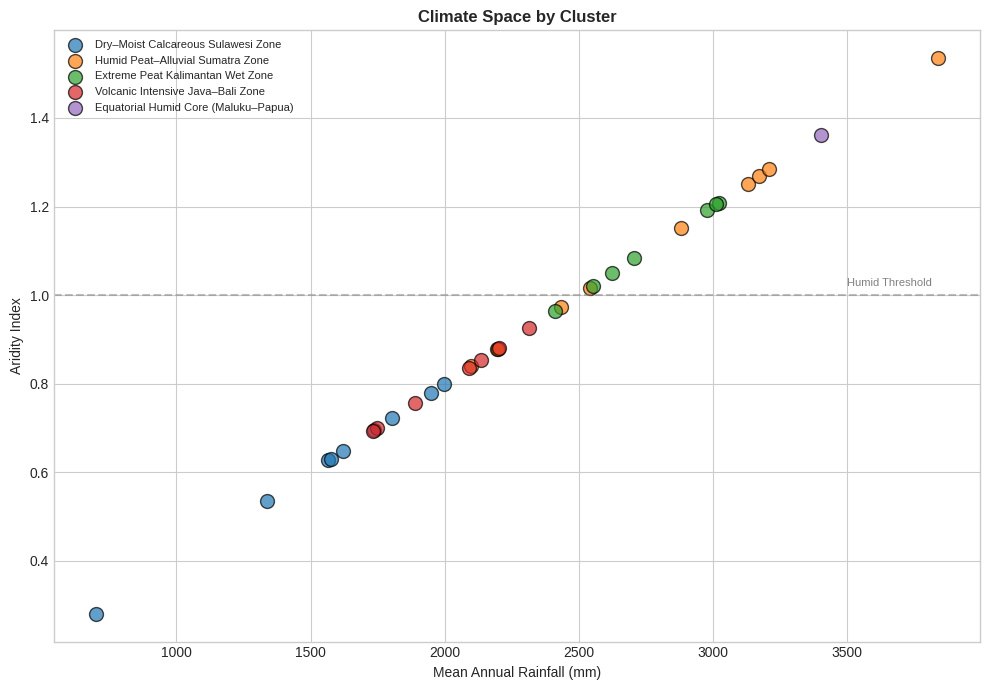

In [544]:
plt.figure(figsize=(10, 7))

colors = plt.cm.tab10(range(OPTIMAL_K))

for cluster in range(OPTIMAL_K):
    cluster_data = features_df[features_df['Cluster_KMeans'] == cluster]
    plt.scatter(
        cluster_data['Mean_Annual_Rainfall'],
        cluster_data['Aridity_Index'],
        s=100,
        alpha=0.7,
        edgecolors='black',
        color=colors[cluster],
        label=cluster_names.get(cluster, f'Cluster {cluster}')
    )

plt.xlabel('Mean Annual Rainfall (mm)')
plt.ylabel('Aridity Index')
plt.title('Climate Space by Cluster', fontweight='bold')
plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
plt.text(3500, 1.02, 'Humid Threshold', fontsize=8, color='gray')
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()


In [545]:
# Prepare export dataframe
export_df = features_df[[
    'Provinsi', 'Region', 'Cluster_KMeans', 'Cluster_Name',
    'Mean_Annual_Rainfall', 'Mean_Rainy_Days', 'Rainfall_Variability',
    'Aridity_Index', 'Climate_Zone',
    'Soil_Volcanic', 'Soil_Alluvial', 'Soil_Organic_Peat', 'Soil_Calcareous',
    'Soil_Quality_Index',
    'Primary_Crops', 'Diversification_Crops'
]].copy()

export_df = export_df.sort_values(['Cluster_KMeans', 'Provinsi'])
export_df.to_csv('hasil_clustering_diversifikasi.csv', index=False, encoding='utf-8')
print("hasil_clustering_diversifikasi Berhasil di Simpan!")

hasil_clustering_diversifikasi Berhasil di Simpan!!
